# Title of notebook

Brief 1-2 sentence description of notebook.

In [3]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert


In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [7]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [8]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [9]:
ORDER=4
FREQ_BAND = [3, 12]
numerator_b, denominator_a = butter(ORDER, FREQ_BAND, fs=LFP_SAMPLING_RATE, btype='band')

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [10]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [11]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [12]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting all the timestamps of the LFPs

In [140]:
BASIC_LFP_TRACES_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [141]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [142]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

BASIC_LFP_TRACES_DF["lfp_baseline_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [143]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

BASIC_LFP_TRACES_DF["lfp_baseline_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

# Syncing LFP and spikes

In [144]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("./proc/all_spike_time.csv")

In [145]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["spike_times"] - MERGED_SPIKE_TRIAL_DF["closest_trial"]
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] // (EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

In [146]:
MERGED_SPIKE_TRIAL_DF = MERGED_SPIKE_TRIAL_DF[np.abs(MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]) <= TRIAL_DURATION * EPHYS_SAMPLING_RATE].reset_index(drop=True)

In [147]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]

0        -199415
1        -199349
2        -198989
3        -198172
4        -198082
           ...  
103994    197866
103995    198511
103996    198878
103997    199693
103998    199995
Name: ephys_sample_from_trial_onset, Length: 103999, dtype: int64

In [148]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"]

0        -9971
1        -9968
2        -9950
3        -9909
4        -9905
          ... 
103994    9893
103995    9925
103996    9943
103997    9984
103998    9999
Name: lfp_sample_from_trial_onset, Length: 103999, dtype: int64

In [222]:
MERGED_SPIKE_TRIAL_DF["cluster_id_with_file_name"] = MERGED_SPIKE_TRIAL_DF["cluster_id"].astype(str) + "_" + MERGED_SPIKE_TRIAL_DF["recording_name"]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [223]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   7019726  20230619_115321_standard_comp_to_omission_D3_s...   
1   9119725  20230619_115321_standard_comp_to_omission_D3_s...   
2  14619719  20230619_115321_standard_comp_to_omission_D3_s...   
3  15619721  20230619_115321_standard_comp_to_omission_D3_s...   
4  17219723  20230619_115321_standard_comp_to_omission_D3_s...   

                                      recording_file  time_stamp_index  \
0  20230619_115321_standard_comp_to_omission_D3_s...           5377470   
1  20230619_115321_standard_comp_to_omission_D3_s...           7477469   
2  20230619_115321_standard_comp_to_omission_D3_s...          12977463   
3  20230619_115321_standard_comp_to_omission_D3_s...          13977465   
4  20230619_115321_standard_comp_to_omission_D3_s...          15577467   

                                          video_file  video_frame  \
0  20230619_115321_standard_comp_to_omission_D3_s...         5367   
1  20230619_115321_standard_comp_to_omission_D3_s...         7464   
2  20230619_115321_standard_comp_to_omission_D3_s...        12953   
3  20230619_115321_standard_comp_to_omission_D3_s...        13951   
4  20230619_115321_standard_comp_to_omission_D3_s...        15548   

   video_number    subject_info competition_closeness  \
0           4.0  1-4_t3b3L_box2             lose_comp   
1           4.0  1-4_t3b3L_box2             lose_comp   
2           4.0  1-4_t3b3L_box2             lose_comp   
3           4.0  1-4_t3b3L_box2             lose_comp   
4           4.0  1-4_t3b3L_box2             lose_comp   

                                          video_name  ...  \
0  20230619_115321_standard_comp_to_omission_D3_s...  ...   
1  20230619_115321_standard_comp_to_omission_D3_s...  ...   
2  20230619_115321_standard_comp_to_omission_D3_s...  ...   
3  20230619_115321_standard_comp_to_omission_D3_s...  ...   
4  20230619_115321_standard_comp_to_omission_D3_s...  ...   

                                     BLA_trial_phase  \
0  [2.1624116758467715, 2.4429794115230368, 2.460...   
1  [2.060322631239531, 2.2535050560700562, 2.2674...   
2  [2.2241103763690298, 2.562095803267324, 2.5862...   
3  [1.7332941305000906, 1.7644665688882721, 1.782...   
4  [2.5014090469404238, -3.1309223846765457, -3.1...   

                                LH_baseline_filtered  \
0  [0.5518736521451013, 0.5218667762199662, 0.489...   
1  [0.0894596788592445, 0.0800010630768984, 0.070...   
2  [0.002838613046840373, 0.02311249078984641, 0....   
3  [-0.3482501079096777, -0.33424191279135357, -0...   
4  [0.4678761905286161, 0.477070690246481, 0.4863...   

                                   LH_baseline_phase  \
0  [-0.2492779130492871, 0.47536743457820285, 0.5...   
1  [-0.17777822817222358, 0.5944088710610229, 0.7...   
2  [-1.5618874813949828, -1.5037791871171555, -1....   
3  [2.664540031371069, -2.9434103193155488, -2.88...   
4  [-0.9468738936748807, -0.6412146645052049, -0....   

                                   LH_trial_filtered  \
0  [-0.7928298895802667, -0.8076042525557989, -0....   
1  [-0.6036158761561012, -0.6050221327556032, -0....   
2  [-1.0443668114519833, -1.0345281901042884, -1....   
3  [-0.05252920733127827, -0.07528796571895098, -...   
4  [0.042177015134895676, 0.06348138037458038, 0....   

                                      LH_trial_phase  \
0  [2.237297797600628, 2.585778428940189, 2.60494...   
1  [2.290689411668095, 2.6902532691958223, 2.7081...   
2  [2.388420265423009, 2.883407682001139, 2.91533...   
3  [1.6951927168159546, 1.7481568692425968, 1.792...   
4  [-1.1934922639820937, -0.9872988769477252, -0....   

                                MD_baseline_filtered  \
0  [0.5295065599073167, 0.4942093334173262, 0.456...   
1  [-0.0620585346648401, -0.07200463557143977, -0...   
2  [-0.028720385905654806, -0.010005955928114929,...   
3  [-0.2730216617918332, -0.25316970011363815, -0...   
4  [0.38051275675979307, 0.4013796122284963, 0.42...   

                  

In [224]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [225]:
FREQ_BAND = [4, 12]


In [226]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [227]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0       12653              64      5557899          64           4        1   
1       12654              89      5557965          89          11       11   
2       12655              60      5558325          60           0        0   
3       12656              64      5559142          64           4        1   
4       12657              89      5559232          89          11       11   

   2ms_isi        amp  ch  channel_group  ...  n_spikes  sh si_unit_id  \
0       12  10.794415  14            0.0  ...     26442   0        9.0   
1       13  17.238409  26            0.0  ...     53080   0       21.0   
2        0  26.088383   5            0.0  ...     11163   0        6.0   
3       12  10.794415  14            0.0  ...     26442   0        9.0   
4       13  17.238409  26            0.0  ...     53080   0       21.0   

                                      recording_name  timestamp_isi  \
0  20230620_114347_standard_comp_to_omission_D4_s...         5967.0   
1  20230620_114347_standard_comp_to_omission_D4_s...         1820.0   
2  20230620_114347_standard_comp_to_omission_D4_s...         5792.0   
3  20230620_114347_standard_comp_to_omission_D4_s...         1243.0   
4  20230620_114347_standard_comp_to_omission_D4_s...         1267.0   

   current_isi closest_trial  ephys_sample_from_trial_onset  \
0      0.29835       5757314                        -199415   
1      0.09100       5757314                        -199349   
2      0.28960       5757314                        -198989   
3      0.06215       5757314                        -198172   
4      0.06335       5757314                        -198082   

   lfp_sample_from_trial_onset  \
0                        -9971   
1                        -9968   
2                        -9950   
3                        -9909   
4                        -9905   

                           cluster_id_with_file_name  
0  64_20230620_114347_standard_comp_to_omission_D...  
1  89_20230620_114347_standard_comp_to_omission_D...  
2  60_20230620_114347_standard_comp_to_omission_D...  
3  64_20230620_114347_standard_comp_to_omission_D...  
4  89_20230620_114347_standard_comp_to_omission_D...  

[5 rows x 23 columns]

(0.0, 10000.0)

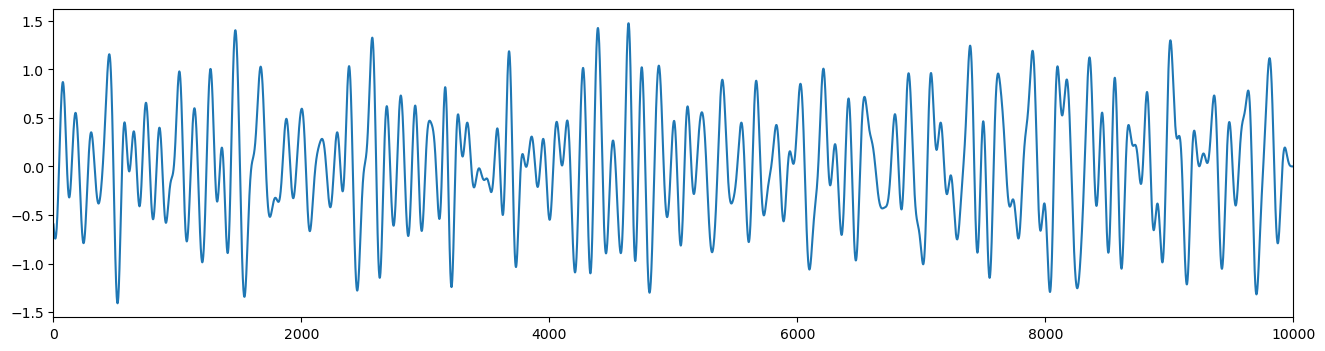

In [228]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

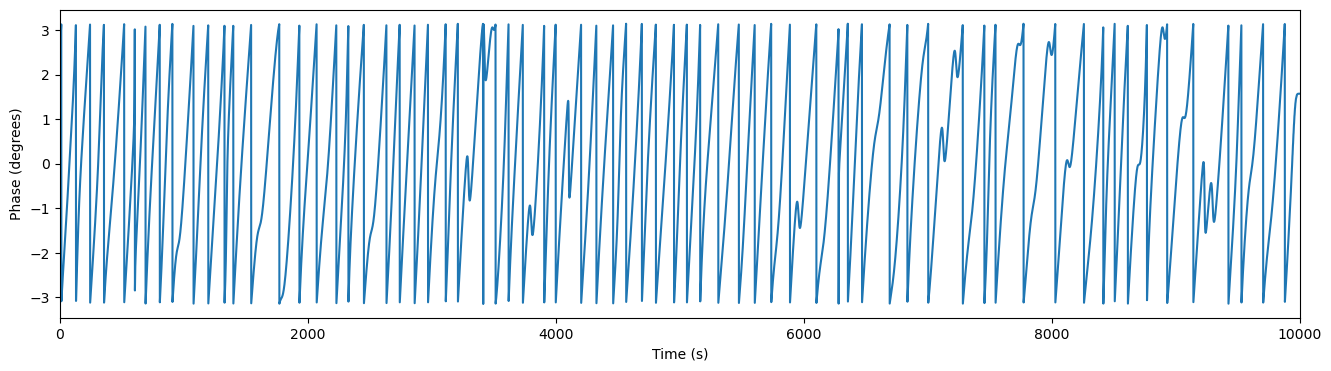

In [229]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

In [230]:
BASIC_LFP_TRACES_DF

time                                      recording_dir  \
0    7019726  20230619_115321_standard_comp_to_omission_D3_s...   
1    9119725  20230619_115321_standard_comp_to_omission_D3_s...   
2   14619719  20230619_115321_standard_comp_to_omission_D3_s...   
3   15619721  20230619_115321_standard_comp_to_omission_D3_s...   
4   17219723  20230619_115321_standard_comp_to_omission_D3_s...   
..       ...                                                ...   
73  63160874  20230620_114347_standard_comp_to_omission_D4_s...   
74  64660893  20230620_114347_standard_comp_to_omission_D4_s...   
75  66660918  20230620_114347_standard_comp_to_omission_D4_s...   
76  68560944  20230620_114347_standard_comp_to_omission_D4_s...   
77  69560954  20230620_114347_standard_comp_to_omission_D4_s...   

                                       recording_file  time_stamp_index  \
0   20230619_115321_standard_comp_to_omission_D3_s...           5377470   
1   20230619_115321_standard_comp_to_omission_D3_s...           7477469   
2   20230619_115321_standard_comp_to_omission_D3_s...          12977463   
3   20230619_115321_standard_comp_to_omission_D3_s...          13977465   
4   20230619_115321_standard_comp_to_omission_D3_s...          15577467   
..                                                ...               ...   
73  20230620_114347_standard_comp_to_omission_D4_s...          60657993   
74  20230620_114347_standard_comp_to_omission_D4_s...          62158012   
75  20230620_114347_standard_comp_to_omission_D4_s...          64158037   
76  20230620_114347_standard_comp_to_omission_D4_s...          66058063   
77  20230620_114347_standard_comp_to_omission_D4_s...          67058073   

                                           video_file  video_frame  \
0   20230619_115321_standard_comp_to_omission_D3_s...         5367   
1   20230619_115321_standard_comp_to_omission_D3_s...         7464   
2   20230619_115321_standard_comp_to_omission_D3_s...        12953   
3   20230619_115321_standard_comp_to_omission_D3_s...        13951   
4   20230619_115321_standard_comp_to_omission_D3_s...        15548   
..                                                ...          ...   
73  20230620_114347_standard_comp_to_omission_D4_s...        60596   
74  20230620_114347_standard_comp_to_omission_D4_s...        62093   
75  20230620_114347_standard_comp_to_omission_D4_s...        64089   
76  20230620_114347_standard_comp_to_omission_D4_s...        65986   
77  20230620_114347_standard_comp_to_omission_D4_s...        66984   

    video_number     subject_info competition_closeness  \
0            4.0   1-4_t3b3L_box2             lose_comp   
1            4.0   1-4_t3b3L_box2             lose_comp   
2            4.0   1-4_t3b3L_box2             lose_comp   
3            4.0   1-4_t3b3L_box2             lose_comp   
4            4.0   1-4_t3b3L_box2             lose_comp   
..           ...              ...                   ...   
73           1.0  1-2_t3b3L_box_1              rewarded   
74           1.0  1-2_t3b3L_box_1              rewarded   
75           1.0  1-2_t3b3L_box_1              omission   
76           1.0  1-2_t3b3L_box_1              rewarded   
77           1.0  1-2_t3b3L_box_1              rewarded   

                                           video_name  ...  \
0   20230619_115321_standard_comp_to_omission_D3_s...  ...   
1   20230619_115321_standard_comp_to_omission_D3_s...  ...   
2   20230619_115321_standard_comp_to_omission_D3_s...  ...   
3   20230619_115321_standard_comp_to_omission_D3_s...  ...   
4   20230619_115321_standard_comp_to_omission_D3_s...  ...   
..                                                ...  ...   
73  20230620_114347_standard_comp_to_omission_D4_s...  ...   
74  20230620_114347_standard_comp_to_omission_D4_s...  ...   
75  20230620_114347_standard_comp_to_omission_D4_s...  ...   
76  20230620_114347_standard_comp_to_omission_D4_s...  ...   
77  20230620_114347_standard_comp_to_omission_D4_s...  ...   

       

In [231]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [232]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [233]:
TRACE_AND_SPIKE_DF["mPFC_trial_phase"].iloc[0].shape

(10000,)

In [234]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9982
1        -9950
2        -9939
3        -9933
4        -9925
          ... 
103994    9911
103995    9956
103996    9963
103997    9972
103998    9998
Name: lfp_sample_from_trial_onset, Length: 103999, dtype: int64

In [235]:
phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "phase" in col]

In [236]:
for col in phase_columns:
    region_name = "_".join(col.split("_")[:2])
    TRACE_AND_SPIKE_DF["{}_spike_phase".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

In [237]:
TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

0        -0.944314
1         0.495475
2         0.960998
3         1.213171
4         1.546641
            ...   
103994    1.714070
103995   -2.528384
103996   -2.244050
103997   -1.894557
103998   -1.570798
Name: mPFC_trial_spike_phase, Length: 103999, dtype: float64

In [238]:
outcome_df["cluster_id"].unique()

array([ 89,  64,  60,  34,  20,  85,  22,   2,  94,  90,  93,  57,  48,
       207, 153,  42, 258, 162,  43,  53, 203, 144, 259, 181, 124, 254,
       227,  58, 241,  45,  41, 251, 139, 168,  14, 221,  50, 244, 220,
       245, 226, 172])

In [240]:
TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()[0]

'204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged'

In [246]:
phase_bins

array([-3.14159265, -2.7925268 , -2.44346095, -2.0943951 , -1.74532925,
       -1.3962634 , -1.04719755, -0.6981317 , -0.34906585,  0.        ,
        0.34906585,  0.6981317 ,  1.04719755,  1.3962634 ,  1.74532925,
        2.0943951 ,  2.44346095,  2.7925268 ,  3.14159265])

In [252]:
spike_phase_hist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [274]:
from sklearn import preprocessing as pre



In [281]:
pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T


array([[0.        , 0.58823529, 0.70588235, 1.        , 0.88235294,
        0.94117647, 0.76470588, 0.82352941, 0.52941176, 0.41176471,
        0.70588235, 0.64705882, 0.88235294, 0.58823529, 0.58823529,
        0.52941176, 0.41176471, 0.47058824, 0.58823529]])

In [292]:
import math

In [293]:
def PPC(spike_phases):
    sp_complex = map(lambda x: [math.cos(x), math.sin(x)], spike_phases)
    all_com = list(itertools.combinations(sp_complex , 2))
    dp_array = np.empty(int(len(spike_phases) * (len(spike_phases) - 1) / 2))
    for d, combination in enumerate(all_com):
        dp = np.dot(combination[0], combination[1])
        dp_array[d] = dp
    dp_sum = np.sum(dp_array)
    ppc = dp_sum / len(dp_array)
    return ppc


In [294]:
ppc_val = PPC(spike_phases)
print('PPC: ' + str(ppc_val))

PPC: -0.00043389651048236744


[  0. 103. 132. 117. 142. 131. 128. 137. 113. 144. 125. 110. 121. 141.
 128. 121. 150. 123. 137.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 53. 54. 40. 53. 56. 49. 48. 52. 46. 48. 45. 41. 52. 45. 51. 53. 44.
 60.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


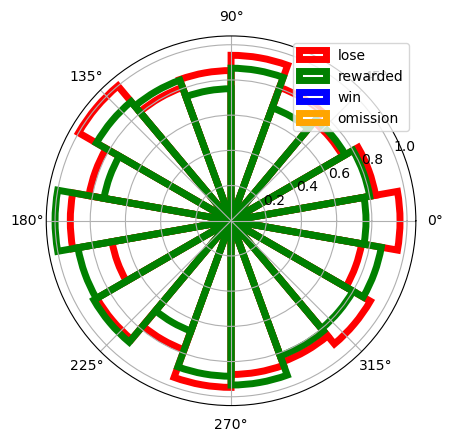

[  0. 218. 221. 223. 223. 238. 223. 200. 226. 223. 234. 217. 199. 224.
 240. 229. 214. 238. 223.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 44. 40. 44. 57. 42. 58. 42. 53. 42. 49. 60. 56. 45. 47. 45. 38. 50.
 37.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


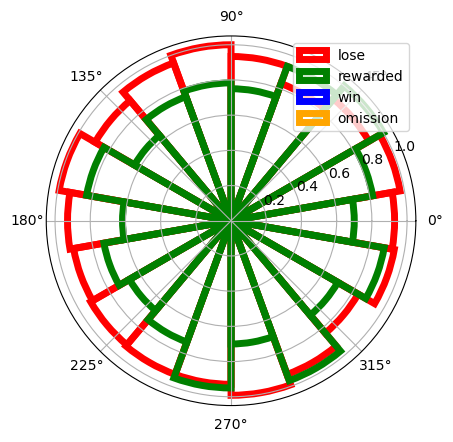

[  0. 158. 195. 182. 178. 212. 172. 173. 163. 178. 155. 152. 158. 172.
 149. 174. 164. 157. 155.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0.  66.  91.  80.  79. 100.  86.  97.  74.  58.  72.  78.  75.  88.
  76.  73.  66.  70.  90.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


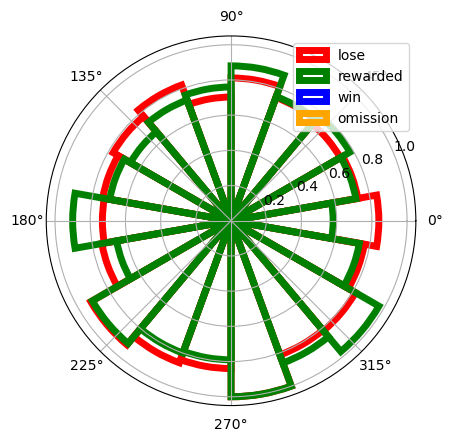

[  0. 124. 110. 120. 111. 114. 107. 118. 114.  95. 128. 109. 112. 106.
 115. 113. 111. 100. 111.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  6.  9.  9.  7. 14.  2.  6.  4.  6.  5.  4.  5.  4.  9.  7.  9.  9.
  6.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


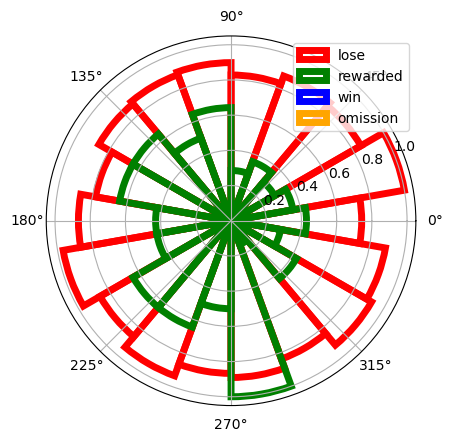

[ 0. 47. 39. 51. 50. 41. 46. 33. 30. 53. 53. 37. 40. 48. 42. 40. 46. 46.
 48.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 1. 1. 0. 1. 1. 6. 0. 3. 1. 1. 0. 3. 2. 3. 0. 3. 2. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


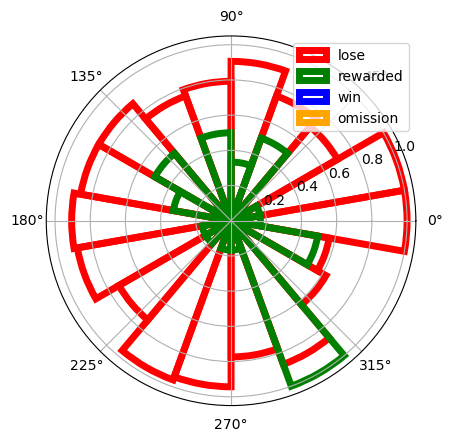

[ 0.  7. 14. 11. 14.  8.  5. 14.  7.  9.  8.  5.  6. 12.  8.  6.  5.  6.
 14.]
[0. 1. 1. 0. 2. 1. 3. 0. 4. 0. 2. 1. 1. 0. 3. 0. 2. 2. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


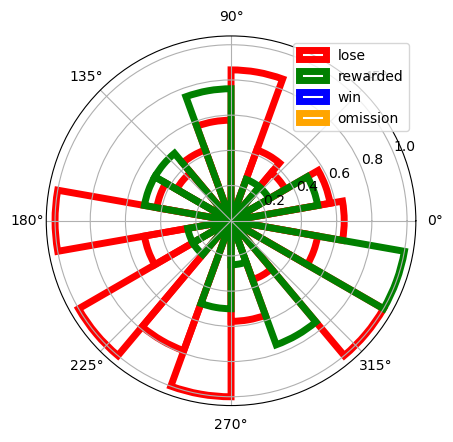

[ 0. 39. 42. 57. 35. 39. 26. 40. 38. 35. 43. 35. 38. 45. 43. 47. 36. 31.
 47.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 13. 12. 15. 13. 21.  9.  5.  8.  7.  6.  9. 14. 15.  6. 15. 12. 13.
  9.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


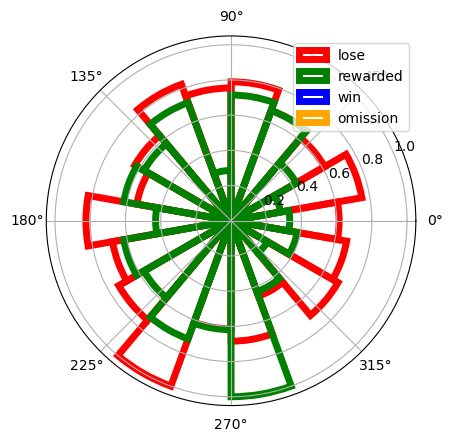

[ 0. 74. 71. 95. 97. 82. 85. 79. 96. 90. 79. 68. 89. 62. 79. 79. 85. 74.
 66.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 68. 67. 71. 67. 61. 61. 62. 51. 78. 75. 65. 67. 62. 75. 52. 51. 78.
 65.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


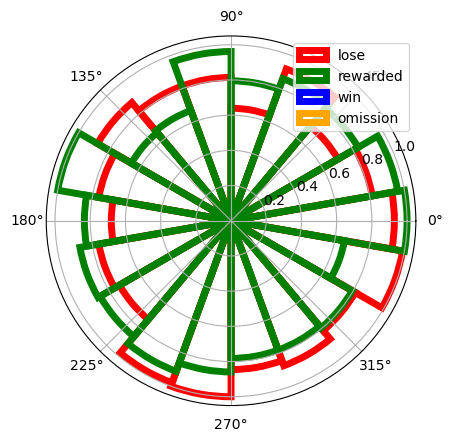

[ 0. 15. 12. 14.  7. 18. 11. 10. 16.  8.  7. 17.  9.  7. 10. 10. 12. 11.
  8.]
[0. 3. 1. 4. 1. 1. 1. 3. 1. 0. 0. 2. 0. 1. 4. 0. 2. 2. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


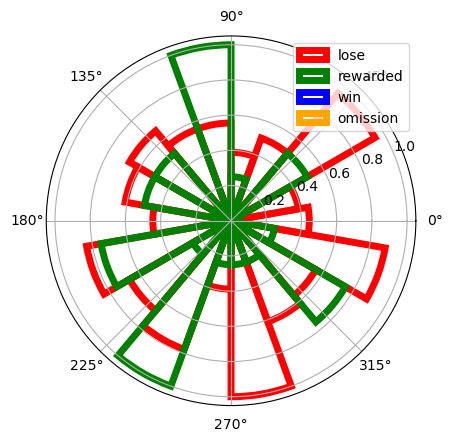

[ 0. 32. 33. 33. 24. 42. 27. 35. 37. 36. 32. 21. 30. 30. 34. 37. 38. 28.
 38.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 21. 30. 21. 21. 30. 23. 24. 16. 21. 19. 37. 38. 24. 21. 34. 25. 25.
 32.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


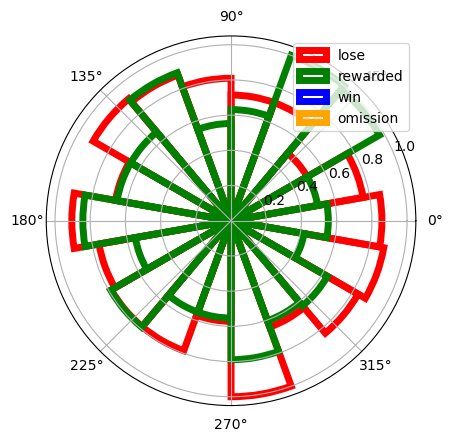

[ 0. 43. 32. 37. 40. 35. 35. 25. 32. 28. 31. 37. 32. 26. 28. 35. 43. 39.
 38.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 10.  9.  9. 10.  6.  8. 10.  9.  9. 12. 10. 11.  8. 12. 10. 12.  8.
  6.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


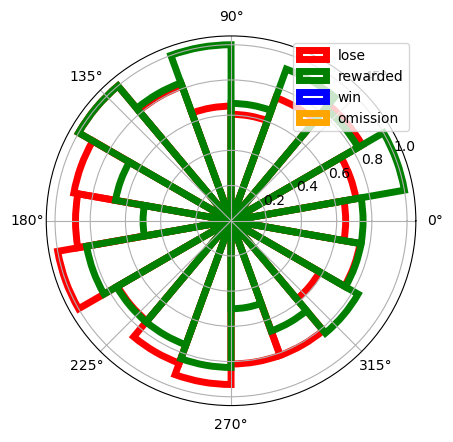

[ 0. 13. 30. 27. 33. 16. 19. 19. 24. 21. 22. 16. 29. 28. 26. 29. 24. 21.
 28.]
[0. 1. 2. 3. 8. 2. 3. 4. 2. 2. 5. 2. 5. 2. 2. 1. 8. 3. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


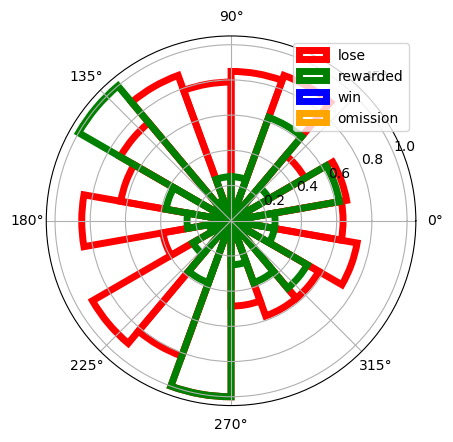

[ 0.  8.  7.  9. 14. 11. 16.  7.  8. 11. 10. 12.  8.  9. 13. 12. 11.  9.
 11.]
[0. 1. 1. 3. 1. 1. 0. 2. 1. 2. 2. 1. 0. 1. 3. 1. 0. 0. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


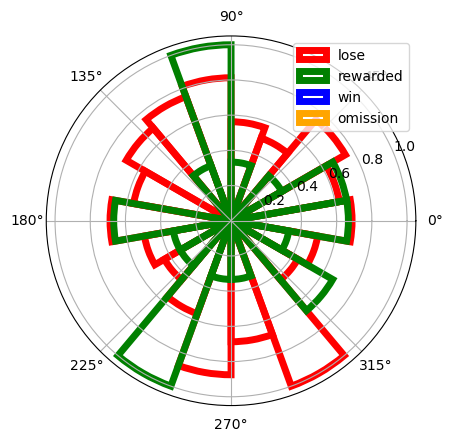

[ 0.  7. 11. 15.  6. 20.  9.  6.  8. 10.  9.  9. 10. 10.  8. 13. 13.  9.
 17.]
[0. 2. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)
/tmp/ipykernel_306692/3548215221.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ppc = dp_sum / len(dp_array)


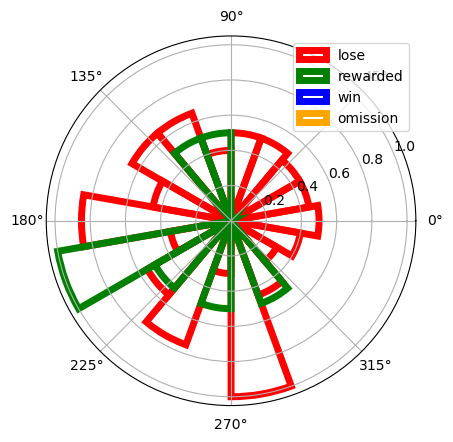

[ 0. 45. 59. 48. 50. 69. 64. 42. 50. 50. 49. 54. 47. 42. 49. 54. 45. 43.
 46.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 150. 156. 157. 152. 134. 121. 127. 127. 131. 121. 122. 114. 125.
 124. 137. 127. 117. 123.]
[ 0. 68. 73. 72. 76. 73. 74. 74. 64. 75. 64. 65. 58. 62. 70. 67. 63. 63.
 87.]
[ 0. 29. 26. 29. 31. 27. 21. 32. 27. 26. 22. 28. 20. 24. 28. 24. 27. 25.
 19.]


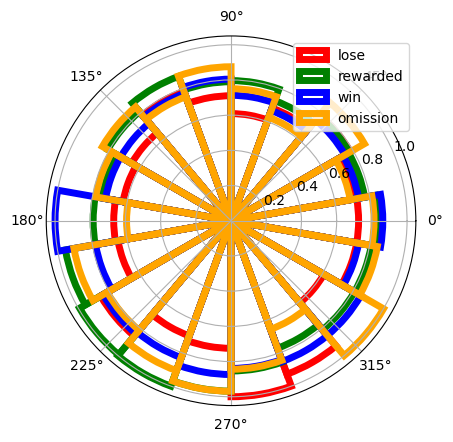

[ 0. 87. 78. 82. 92. 73. 72. 84. 73. 79. 81. 79. 77. 85. 95. 71. 85. 81.
 60.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 209. 233. 234. 238. 261. 243. 241. 217. 230. 206. 241. 207. 204.
 193. 214. 216. 197. 224.]
[  0. 119. 124. 121. 122. 117. 118. 120. 132. 117. 117. 104. 123. 118.
 105. 115. 126. 127. 115.]
[ 0. 55. 65. 50. 55. 49. 54. 70. 61. 52. 67. 52. 48. 53. 55. 51. 58. 51.
 47.]


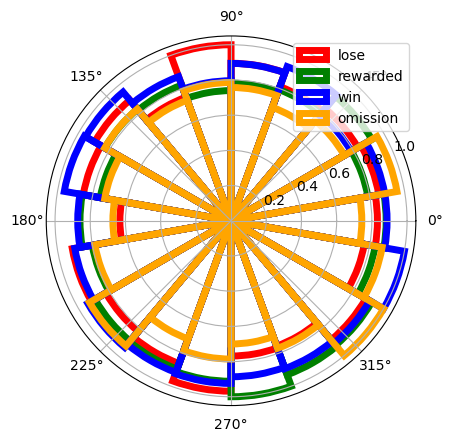

[ 0. 21. 28. 25. 29. 21. 25. 24. 19. 22. 34. 25. 19. 22. 30. 26. 27. 15.
 30.]
[ 0. 73. 61. 73. 70. 73. 57. 77. 74. 58. 69. 67. 75. 76. 67. 55. 76. 59.
 79.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 23. 35. 30. 22. 37. 19. 36. 42. 26. 32. 24. 28. 25. 33. 38. 43. 18.
 32.]
[ 0.  5. 12.  9.  4. 10. 11. 11.  8.  6. 10. 10. 11.  7.  7.  5. 12.  6.
  8.]


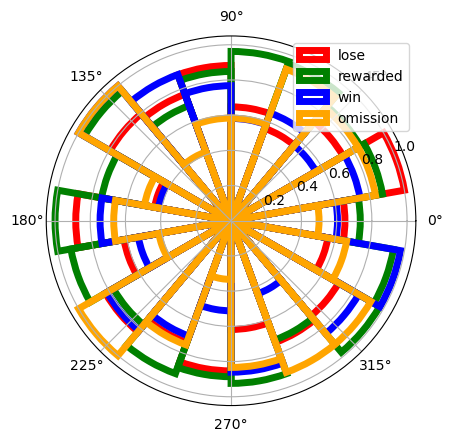

[0. 1. 2. 4. 1. 2. 1. 1. 1. 2. 0. 3. 7. 1. 1. 0. 2. 1. 3.]
[ 0.  8.  8.  9. 14.  9.  7.  6. 11. 13. 13.  8. 13.  6.  8.  6. 13. 12.
  9.]
[0. 2. 1. 5. 3. 7. 3. 4. 1. 4. 3. 3. 1. 3. 3. 4. 7. 1. 4.]
[0. 3. 5. 5. 2. 1. 0. 1. 2. 4. 3. 1. 1. 2. 1. 1. 2. 1. 1.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


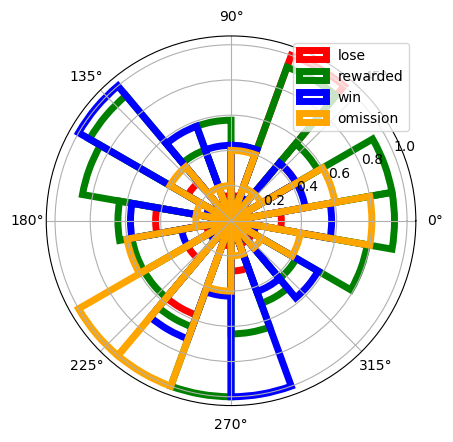

[0. 2. 5. 3. 3. 2. 3. 3. 5. 6. 3. 2. 3. 3. 4. 4. 0. 4. 4.]
[ 0. 12. 10. 12. 10. 18. 12.  9. 10. 17. 12.  8.  8. 12. 17.  9.  7.  8.
  8.]
[0. 5. 6. 4. 7. 8. 5. 8. 5. 5. 1. 6. 3. 6. 8. 5. 2. 5. 4.]
[0. 3. 2. 2. 1. 2. 1. 3. 0. 2. 0. 1. 1. 1. 3. 1. 0. 2. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


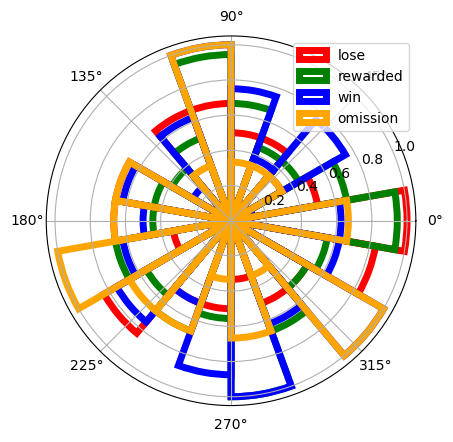

[0. 0. 2. 1. 1. 0. 1. 1. 0. 0. 2. 2. 2. 2. 4. 1. 3. 3. 1.]
[ 0. 40. 38. 33. 26. 23. 36. 26. 30. 42. 36. 33. 32. 37. 23. 26. 27. 29.
 28.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 4. 8. 3. 6. 5. 4. 6. 6. 1. 6. 4. 6. 5. 5. 8. 4. 7. 6.]
[0. 4. 4. 5. 1. 0. 3. 1. 2. 1. 1. 1. 1. 3. 4. 2. 6. 2. 3.]


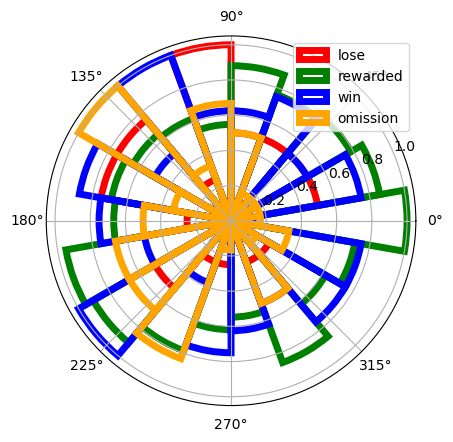

[0. 2. 4. 7. 1. 3. 4. 9. 5. 2. 2. 2. 3. 3. 1. 4. 2. 2. 5.]
[ 0. 14. 13. 12. 13. 22. 16. 13. 15.  8. 12. 15. 18. 11. 11. 17. 14. 11.
 19.]
[ 0.  9.  9.  7.  9.  7.  8. 10.  5. 10. 13.  6.  9. 12. 12.  8.  9. 10.
 14.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 5. 7. 2. 4. 8. 6. 4. 3. 5. 1. 2. 1. 3. 5. 3. 7. 4. 7.]


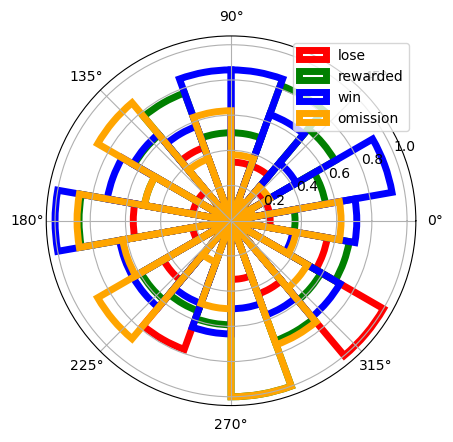

[ 0. 28. 27. 35. 29. 34. 24. 35. 30. 33. 33. 39. 31. 40. 25. 30. 33. 23.
 29.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  4.  9.  7.  8.  3.  8.  9.  4.  8.  6. 10.  9.  5.  5.  5. 11.  6.
  2.]
[ 0. 36. 41. 27. 31. 35. 30. 36. 43. 33. 37. 33. 34. 40. 29. 29. 46. 35.
 39.]
[0. 1. 1. 0. 2. 1. 1. 0. 0. 2. 0. 2. 0. 3. 1. 0. 1. 2. 0.]


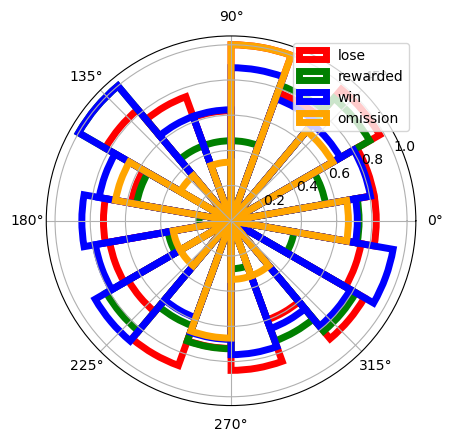

[0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 2. 1. 1. 2. 1. 2.]
[ 0. 25. 20. 17. 15.  9. 12. 16. 17. 10. 18. 18. 13. 17. 16. 20. 21. 15.
 15.]
[0. 2. 0. 3. 3. 2. 2. 2. 3. 2. 2. 0. 2. 2. 2. 1. 1. 0. 3.]
[ 0.  4.  5.  9.  6.  7.  6.  6.  6. 10. 12.  9.  6.  6.  5.  7. 11.  3.
  7.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


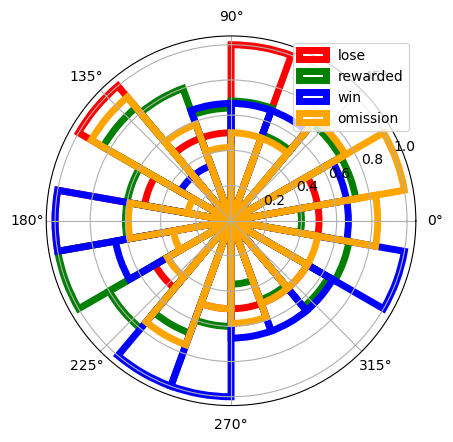

[0. 0. 1. 2. 1. 2. 0. 1. 1. 0. 3. 0. 1. 0. 1. 0. 0. 1. 0.]
[ 0. 11. 11. 19. 15. 11. 13.  8.  9.  5. 14. 14.  8. 13. 10.  7. 15. 18.
 13.]
[0. 3. 2. 0. 4. 0. 0. 1. 3. 0. 0. 1. 0. 4. 2. 1. 4. 1. 2.]
[0. 4. 5. 3. 4. 1. 2. 4. 3. 1. 0. 3. 3. 5. 1. 4. 6. 3. 3.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


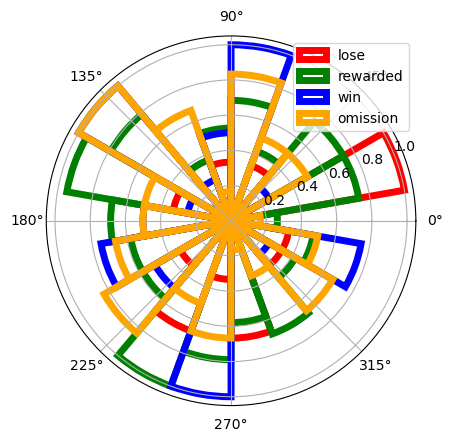

[0. 2. 4. 3. 2. 5. 2. 3. 1. 4. 3. 2. 5. 2. 4. 0. 4. 6. 4.]
[0. 7. 5. 4. 3. 4. 8. 4. 9. 7. 8. 4. 2. 2. 7. 7. 7. 1. 6.]
[0. 1. 4. 5. 4. 2. 3. 2. 6. 6. 3. 1. 5. 2. 4. 4. 4. 2. 2.]
[0. 1. 3. 0. 3. 4. 4. 0. 1. 1. 1. 1. 4. 3. 1. 3. 2. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


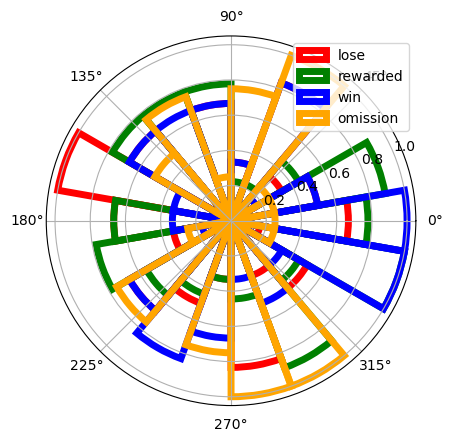

[0. 2. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 2.]
[ 0. 13.  6. 16.  6. 18. 13. 10.  9.  9.  8.  9.  9.  9.  8.  4. 10.  8.
  3.]
[0. 3. 3. 1. 3. 0. 2. 3. 2. 3. 1. 1. 1. 1. 3. 2. 1. 2. 1.]
[0. 1. 3. 5. 2. 2. 2. 2. 6. 1. 2. 1. 4. 1. 2. 3. 1. 2. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


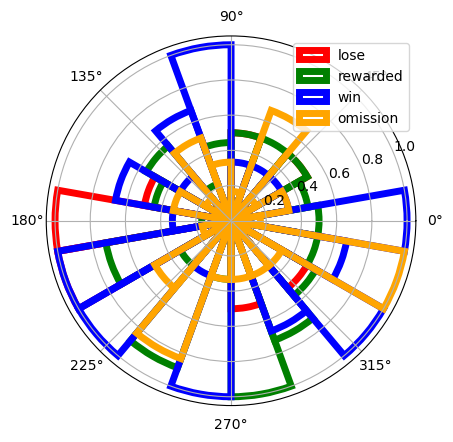

[  0.  91. 100.  92.  98. 102.  95.  93.  66.  95. 107.  89.  83. 102.
  96.  93.  96. 101.  82.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 116. 118. 125. 114. 105. 120.  77. 100. 113. 101. 109. 118. 116.
 127. 104. 141. 137. 120.]
[ 0. 54. 49. 70. 53. 72. 62. 56. 73. 64. 58. 65. 56. 57. 62. 55. 52. 79.
 63.]
[ 0. 28. 24. 24. 23. 19. 35. 19. 25. 26. 22. 18. 19. 18. 33. 27. 25. 22.
 22.]


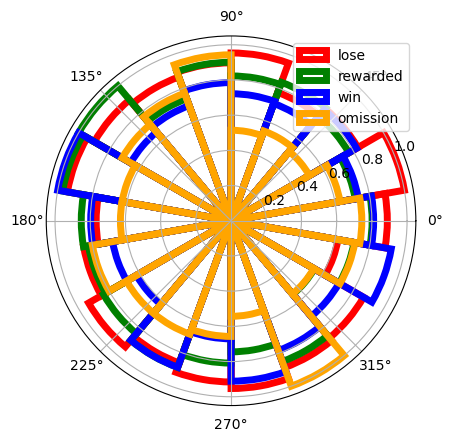

[ 0. 21. 19. 13. 13.  9. 21.  9. 15. 10. 20. 19. 17. 15. 14. 11. 14. 21.
 18.]
[ 0. 13. 14. 15. 14. 11.  8.  8.  9. 11.  9. 14. 10.  9. 13. 17. 22. 10.
 15.]
[ 0. 12.  7.  8. 10.  4.  6.  8.  6.  8.  8.  8.  5.  9.  5.  8. 12. 13.
  9.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 3. 3. 5. 4. 1. 4. 8. 4. 5. 7. 3. 4. 4. 9. 3. 4. 7. 7.]


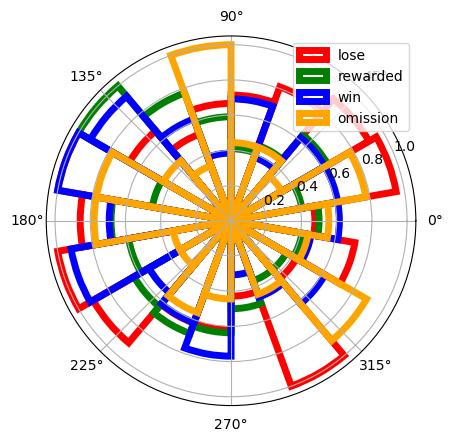

[  0. 102. 133. 127.  84. 107. 110.  95. 116. 109. 109. 118. 114. 116.
 126. 111. 115. 120. 141.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 207. 213. 192. 209. 198. 176. 175. 140. 151. 151. 187. 207. 195.
 201. 185. 225. 225. 216.]
[ 0. 71. 73. 73. 67. 68. 52. 67. 52. 56. 67. 62. 73. 64. 80. 71. 66. 68.
 65.]
[ 0. 57. 45. 55. 37. 62. 50. 38. 51. 50. 52. 55. 45. 50. 54. 51. 60. 43.
 39.]


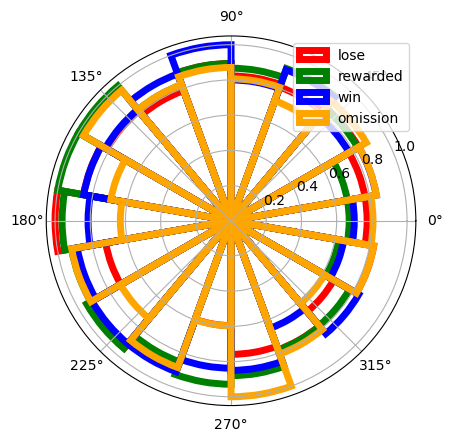

[  0.  85. 100.  82.  93. 102.  90.  87.  74.  80.  81.  83.  76.  79.
 100.  80.  89.  82.  72.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 206. 204. 221. 217. 200. 183. 192. 207. 183. 206. 191. 187. 200.
 166. 179. 211. 214. 188.]
[ 0. 46. 58. 50. 51. 49. 37. 43. 33. 42. 40. 45. 39. 36. 48. 47. 51. 55.
 51.]
[ 0. 37. 56. 43. 39. 46. 48. 39. 39. 36. 47. 46. 41. 60. 49. 40. 45. 37.
 44.]


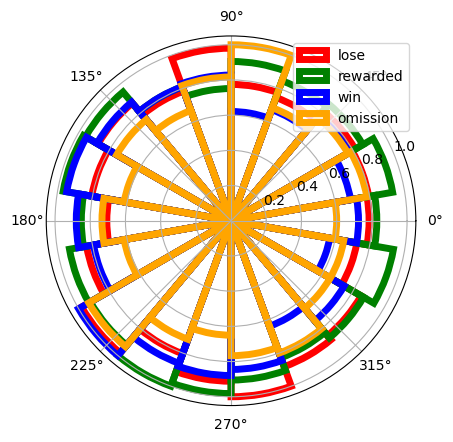

[ 0. 25. 30. 27. 28. 37. 28. 24. 31. 27. 22. 21. 34. 23. 25. 21. 26. 32.
 27.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 103.  91.  85. 104.  80.  87.  91.  77.  90.  82.  87.  88.  95.
  92.  97. 108. 109. 119.]
[ 0. 24. 23. 32. 24. 27. 16. 22. 28. 14. 18. 23. 21. 23. 16. 23. 31. 22.
 21.]
[ 0. 15. 24. 28. 26. 29. 22. 32. 18. 29. 24. 23. 22. 23. 23. 16. 24. 25.
 22.]


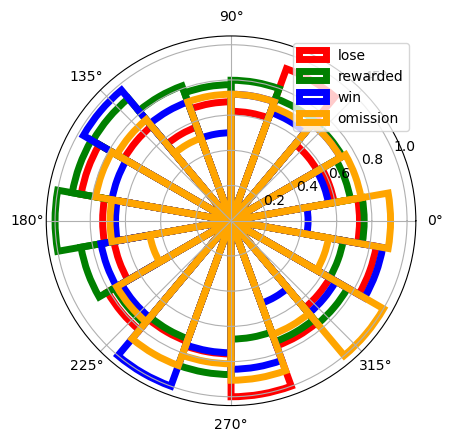

[  0. 133. 133. 144. 146. 130. 147. 125. 121. 151. 142. 139. 147. 141.
 140. 147. 140. 159. 135.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 183. 199. 186. 173. 189. 177. 164. 188. 190. 169. 169. 209. 199.
 210. 184. 201. 200. 171.]
[ 0. 72. 71. 81. 76. 68. 68. 79. 54. 79. 65. 75. 65. 67. 61. 77. 68. 72.
 68.]
[ 0. 39. 37. 38. 28. 34. 39. 32. 27. 38. 29. 40. 35. 37. 45. 47. 37. 32.
 39.]


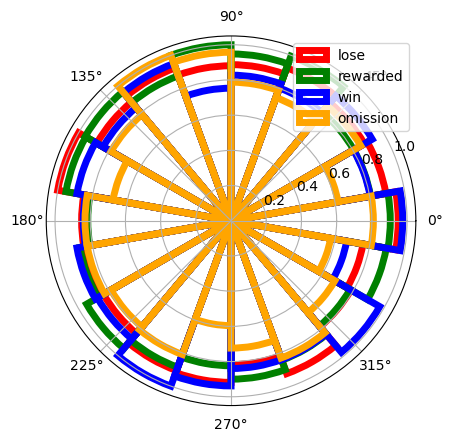

[ 0. 12. 11. 14. 18. 10. 16. 10.  8. 14. 11.  8. 17. 13.  9. 11. 13.  8.
 16.]
[ 0. 35. 33. 31. 34. 36. 20. 21. 26. 35. 28. 22. 25. 18. 27. 25. 26. 25.
 30.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 12. 10.  7. 10. 11.  8.  7.  9.  7.  7.  4. 10.  7.  9.  8.  7. 10.
 11.]
[ 0.  8.  9.  8.  8. 10. 11.  9. 10.  8.  4.  7.  6. 14.  8.  7.  8.  9.
 10.]


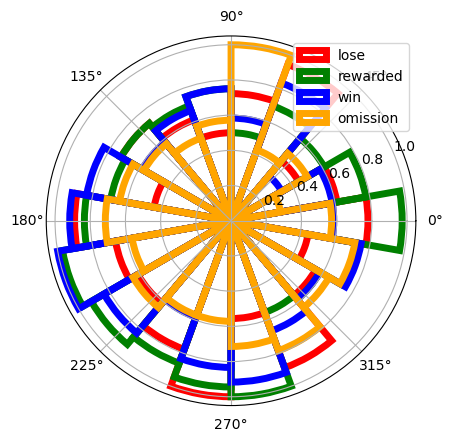

[ 0. 93. 84. 87. 79. 72. 63. 72. 67. 66. 74. 83. 78. 85. 92. 96. 71. 92.
 89.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0. 159. 144. 171. 135. 134. 128. 114. 130. 120. 137. 117. 112. 153.
 136. 128. 144. 136. 142.]
[ 0. 38. 43. 43. 46. 38. 44. 40. 34. 33. 34. 34. 49. 37. 48. 44. 54. 34.
 43.]
[ 0. 43. 38. 30. 35. 34. 27. 25. 39. 23. 17. 37. 22. 27. 38. 29. 29. 34.
 32.]


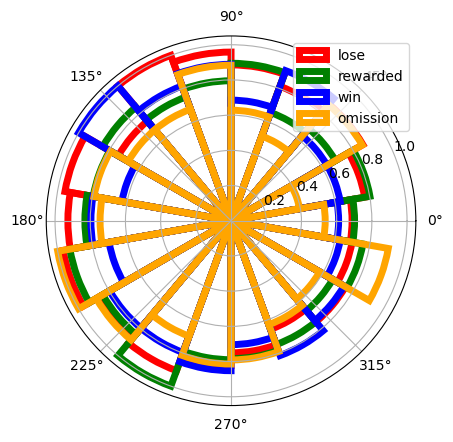

[ 0. 17. 19. 25. 17. 25. 26. 20. 14. 22. 18. 28. 22. 24. 27. 22. 19. 25.
 19.]
[ 0. 16.  6. 11. 16. 15. 10.  6. 16. 15. 13.  4. 11.  8. 11.  9. 13. 12.
 10.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 25. 20. 26. 26. 21. 20. 26. 19. 21. 23. 17. 25. 19. 18. 20. 21. 20.
 29.]
[0. 3. 1. 5. 4. 2. 1. 3. 5. 1. 3. 2. 3. 4. 3. 3. 4. 5. 2.]


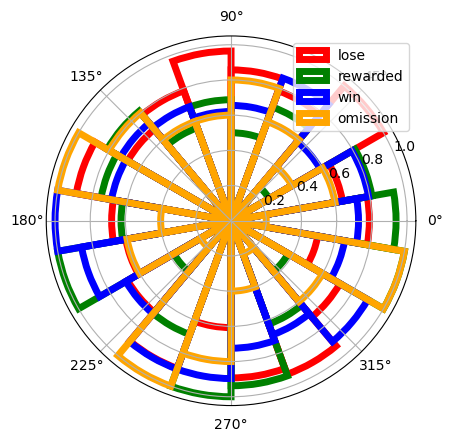

[ 0. 25. 23. 32. 22. 23. 23. 28. 23. 16. 26. 21. 24. 29. 13. 29. 32. 28.
 29.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 53. 32. 56. 50. 42. 32. 31. 38. 34. 45. 41. 30. 34. 37. 40. 50. 37.
 53.]
[ 0. 12. 16.  8. 11. 19. 10. 10.  8.  9. 15. 19. 12. 17. 18. 12.  7. 11.
 13.]
[ 0.  7.  6.  7.  7.  5.  9.  5. 10.  7.  7. 14.  5.  6. 11.  6. 13.  8.
  7.]


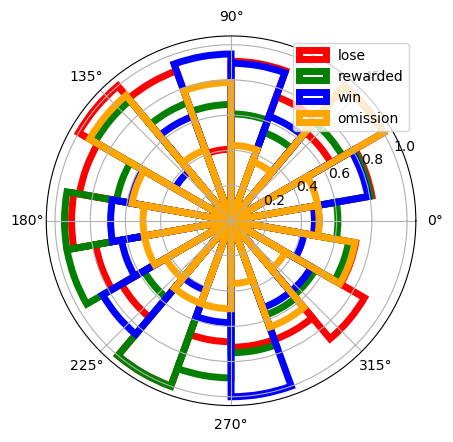

[ 0. 37. 28. 39. 43. 29. 34. 30. 41. 33. 26. 33. 39. 36. 42. 32. 30. 38.
 39.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 40. 38. 33. 48. 40. 36. 40. 25. 33. 37. 38. 36. 28. 33. 37. 43. 37.
 36.]
[ 0. 19. 19. 23. 22. 31. 23. 23. 15. 18. 20. 21. 19. 18. 29. 13. 16. 23.
 26.]
[ 0. 10. 10. 11.  4.  6. 14.  8.  9.  9.  3.  8.  2. 11.  7.  7. 10.  9.
  4.]


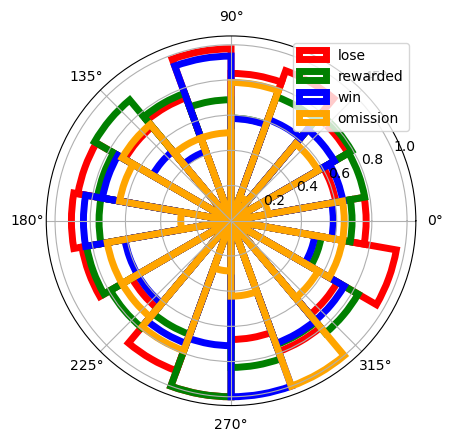

[ 0. 15. 26. 20. 21. 17. 18. 19. 19. 22. 15. 18. 21. 19. 27. 29. 23. 18.
 20.]
[ 0. 54. 35. 56. 47. 52. 46. 32. 40. 37. 45. 46. 35. 30. 44. 40. 43. 52.
 44.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 21. 26. 18. 18. 14. 14. 16. 17. 20. 12.  9. 10. 16. 10. 14. 10. 13.
 18.]
[ 0. 13.  8. 12.  9. 15. 11.  6. 12. 12.  8. 10. 16.  7.  9.  9.  8.  6.
 15.]


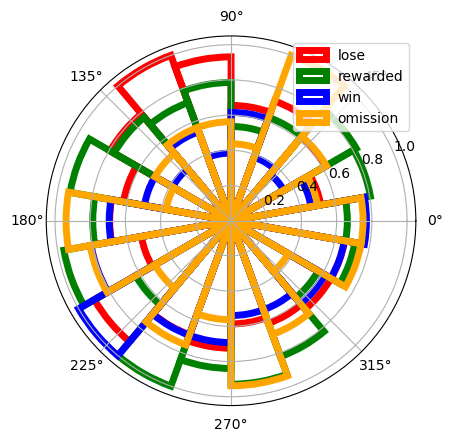

[ 0. 15. 21. 15. 12. 12.  3. 16. 10. 11. 14. 16. 21. 18. 15. 16. 12. 15.
 19.]
[ 0. 57. 54. 47. 66. 43. 37. 56. 43. 53. 51. 43. 54. 68. 46. 60. 59. 57.
 59.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  4. 14.  8. 12.  6.  9.  5.  5. 10. 13.  5. 14.  8. 11.  9.  8.  9.
  9.]
[ 0. 14.  9. 14. 13. 14. 10.  6. 15. 10. 10. 12. 11. 12. 14. 16. 15. 18.
 18.]


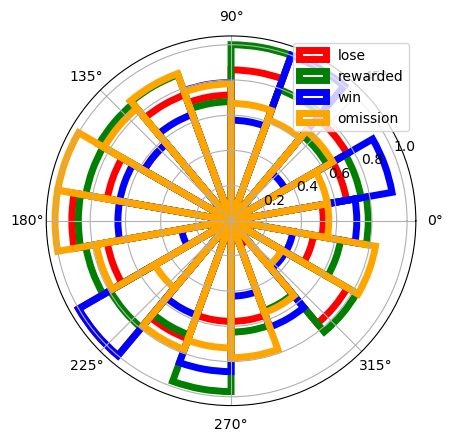

[ 0. 31. 34. 22. 28. 30. 26. 28. 25. 32. 22. 26. 39. 40. 28. 23. 29. 30.
 34.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0.  86.  82.  87.  78.  87.  70.  68. 105.  77.  91.  88.  72.  97.
  80.  81.  77.  73.  80.]
[ 0. 19. 16. 17. 21. 19. 16. 10. 18. 13. 15. 16. 16. 13. 14. 12. 13.  7.
 21.]
[ 0. 26. 18. 27. 20. 23. 21. 16. 14. 19. 25. 23.  6. 17. 24. 21. 14. 27.
 18.]


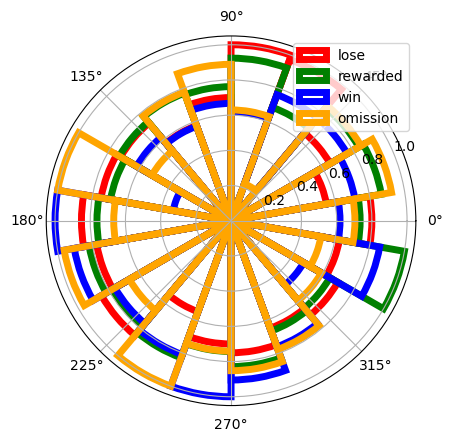

[0. 6. 3. 4. 8. 7. 3. 4. 8. 6. 4. 4. 4. 3. 7. 7. 3. 4. 8.]
[ 0. 14.  8.  7. 11.  5.  3.  3.  6.  7.  8.  5.  3.  6.  4.  4.  5.  4.
  6.]
[0. 4. 3. 5. 4. 4. 3. 1. 2. 3. 3. 0. 5. 2. 7. 4. 2. 3. 2.]
[0. 0. 3. 5. 1. 2. 2. 5. 1. 2. 0. 2. 0. 1. 2. 1. 1. 2. 1.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


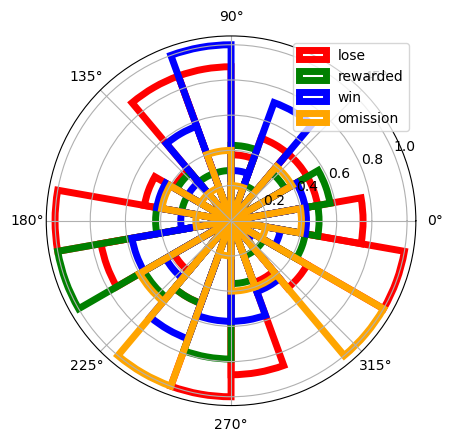

[ 0.  9. 10. 10. 11. 18. 17. 17.  5. 12. 15. 16. 12. 22. 15. 19. 13. 24.
 11.]
[ 0. 28. 31. 32. 35. 23. 27. 34. 22. 27. 30. 32. 29. 31. 41. 36. 29. 30.
 36.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 11.  4. 11.  7.  5.  8. 11.  2.  9.  9.  8. 11.  7.  8.  6. 10. 10.
 10.]
[ 0. 11. 13. 13.  5.  8.  8.  7.  6.  7.  6. 13.  9.  7. 13.  7. 13.  7.
  8.]


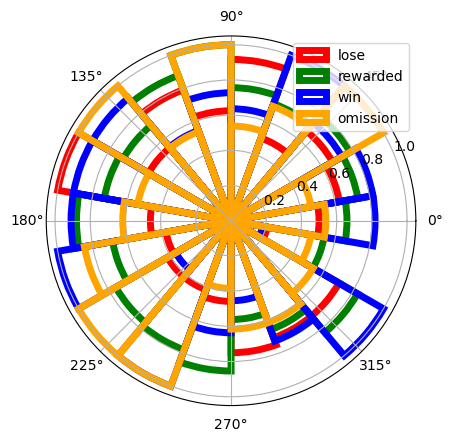

[ 0. 20. 22. 25. 12. 23. 12. 21. 23. 23. 18. 28. 17. 35. 21. 21. 25. 19.
 29.]
[ 0. 40. 41. 62. 46. 37. 38. 42. 32. 52. 44. 42. 44. 51. 52. 48. 51. 50.
 42.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0. 20. 14. 14.  7. 15. 12. 13.  7. 11. 13. 16. 15. 20. 14. 13. 12. 19.
 16.]
[ 0. 20. 14.  9. 12. 13.  9. 10.  5. 14. 16. 11.  6. 14. 11. 16. 20. 16.
  9.]


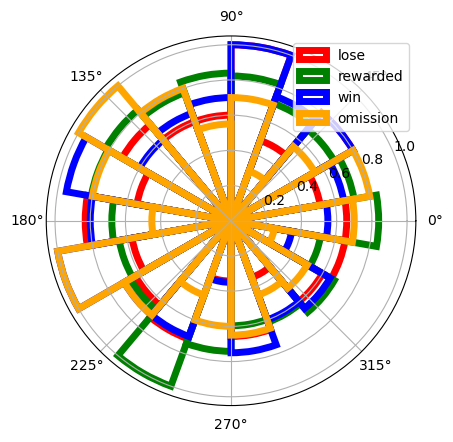

[ 0. 20. 25. 14. 12. 18. 19. 15. 14. 16. 20. 16. 17. 12. 20. 12. 20. 18.
 22.]
[ 0. 20. 14. 17. 15. 16. 13. 14.  6. 10. 13. 14. 16. 13. 14. 22. 27. 15.
 16.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  9. 16. 16. 15. 15. 11. 13. 12. 12. 14. 13. 13.  9. 16.  6. 14. 17.
 15.]
[ 0. 14.  8.  9.  7.  4.  5.  9.  8. 11.  9. 12. 11. 10.  8. 11. 11.  9.
  8.]


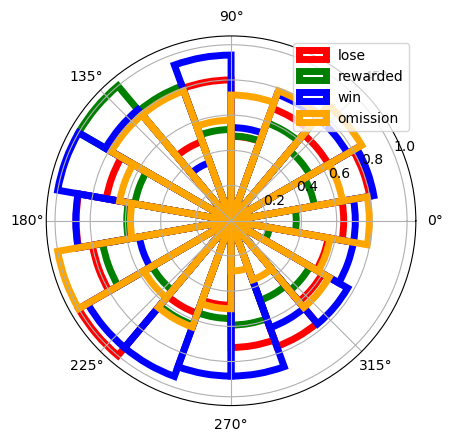

[ 0. 12. 12.  9. 13. 11. 10. 11.  6. 10. 10. 16. 10. 10. 10.  9. 10. 11.
  7.]
[ 0. 30. 21. 25. 28. 20. 33. 35. 28. 24. 25. 24. 32. 22. 26. 35. 26. 26.
 33.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  7.  4. 10.  5.  5.  5.  5.  3.  7.  4.  4.  5.  2.  9.  6.  2.  5.
  4.]
[0. 8. 1. 6. 6. 9. 7. 8. 5. 7. 6. 9. 7. 6. 9. 8. 7. 9. 6.]


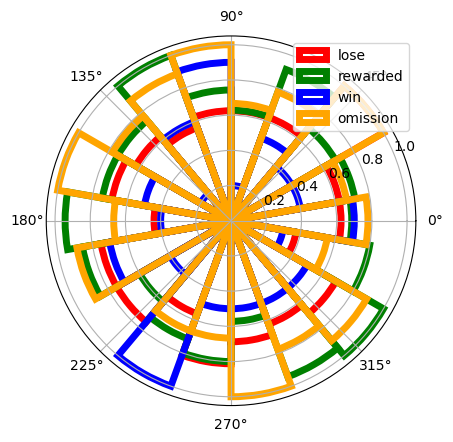

[ 0. 28. 17. 26. 24. 25. 27. 20. 18. 19. 25. 22. 23. 21. 31. 32. 34. 30.
 24.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[ 0.  9.  9. 13. 19. 19. 19. 17. 18. 14. 14. 11. 15. 17. 13. 15. 14. 13.
 19.]
[ 0. 11.  8. 15.  7. 10.  4. 12.  3.  7.  9. 11.  8. 16. 11. 10.  9.  9.
 10.]
[0. 4. 3. 1. 2. 2. 4. 3. 7. 3. 2. 0. 3. 2. 6. 4. 2. 3. 4.]


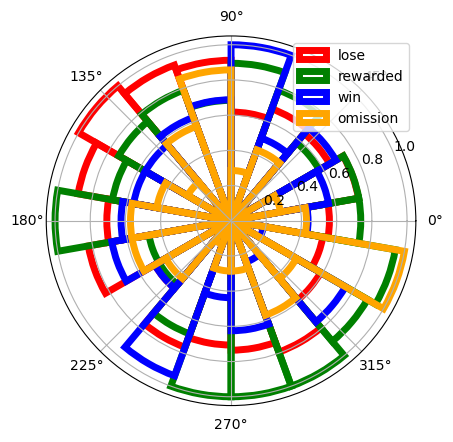

[0. 1. 4. 4. 2. 6. 5. 7. 2. 6. 4. 2. 5. 6. 7. 7. 5. 6. 6.]
[ 0. 15. 25. 13.  6. 13.  9.  9. 10. 10. 10. 19. 12. 10. 13. 15. 15. 20.
 13.]
[ 0.  4.  4.  4.  1.  5.  8.  6.  3.  8.  8.  3.  3.  4. 11.  5.  1.  7.
  5.]
[0. 1. 5. 2. 1. 4. 1. 2. 5. 1. 2. 3. 2. 2. 2. 3. 1. 4. 8.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


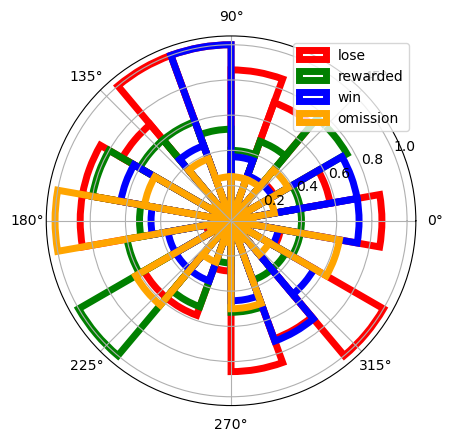

[ 0. 14. 21. 17. 12. 22. 20. 16. 24. 23. 17. 14. 20. 17. 20. 23. 27. 17.
 23.]
[ 0. 13. 14. 13. 13. 10. 15. 16.  7. 15. 18. 11. 17. 12. 12.  7.  7. 16.
 13.]
[ 0. 16.  4. 11.  8. 14. 15. 12.  9.  6. 12. 12.  6.  7. 10.  8. 11. 11.
 15.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 5. 2. 3. 5. 1. 2. 4. 3. 1. 2. 6. 0. 0. 3. 2. 2. 3. 3.]


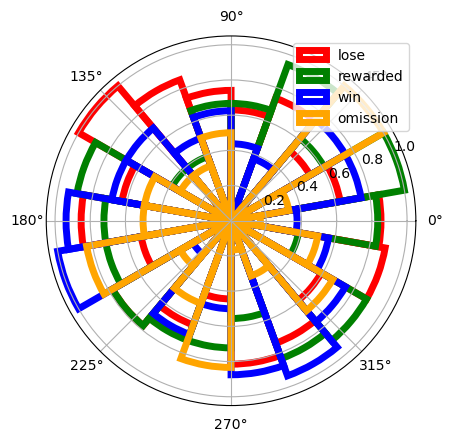

[ 0. 55. 62. 66. 54. 54. 53. 66. 73. 54. 51. 64. 46. 54. 53. 65. 61. 50.
 57.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[  0.  83.  80.  93.  83.  82.  81.  79.  90.  80.  91.  94.  86.  81.
 100.  80.  69.  97. 105.]
[ 0. 35. 33. 29. 30. 31. 29. 28. 18. 28. 22. 20. 29. 30. 31. 31. 27. 28.
 27.]
[ 0. 26. 24. 26. 19. 26. 20. 21. 19. 26. 26. 31. 23. 25. 25. 26. 33. 26.
 26.]


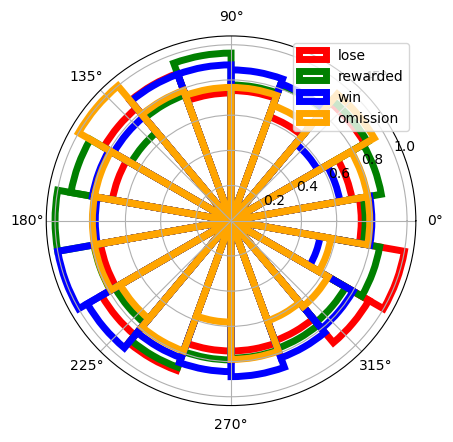

[0. 2. 3. 5. 2. 4. 2. 4. 3. 4. 5. 3. 2. 3. 4. 5. 2. 3. 2.]
[ 0.  8.  5. 10.  7.  6.  7.  9.  9.  5.  5.  6. 10.  2.  5.  4.  5.  4.
  5.]
[0. 2. 4. 1. 3. 2. 3. 4. 5. 4. 5. 2. 6. 1. 1. 1. 4. 1. 2.]
[0. 1. 2. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 3. 0. 0.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


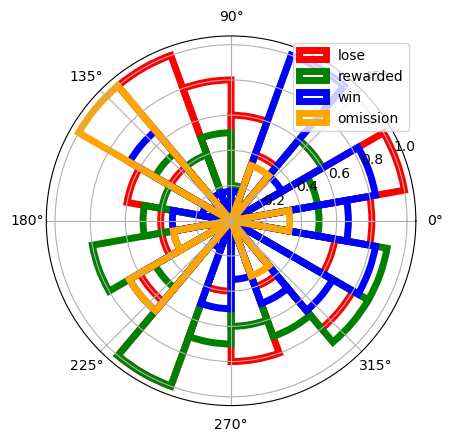

[0. 3. 3. 6. 0. 2. 6. 2. 1. 3. 3. 4. 4. 2. 3. 2. 6. 4. 6.]
[ 0.  4.  4.  1.  6.  5.  4. 10.  6.  3.  7.  5.  3.  5.  5.  2.  6.  9.
  6.]
[0. 1. 1. 1. 1. 1. 2. 0. 3. 2. 1. 2. 0. 0. 1. 1. 1. 0. 0.]
[0. 0. 0. 2. 3. 2. 0. 1. 1. 2. 2. 2. 4. 1. 0. 2. 2. 0. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


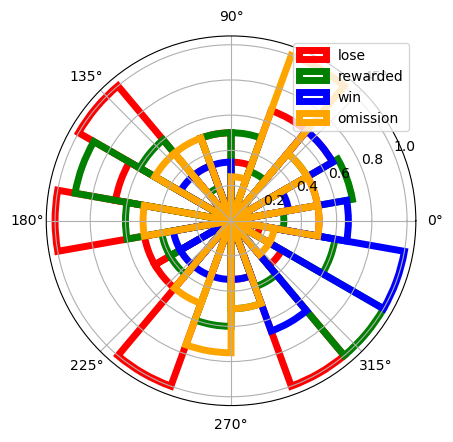

[ 0.  4.  5.  3.  6. 11.  8.  5.  4.  7.  4.  3. 10. 11. 11.  5.  8.  5.
  4.]
[ 0.  7. 11. 10. 10.  8.  9.  7. 12.  5.  4.  9.  6.  8. 10.  7.  4.  4.
  7.]
[0. 3. 6. 8. 2. 4. 1. 1. 1. 2. 1. 2. 8. 9. 3. 2. 5. 4. 4.]
[0. 2. 1. 0. 0. 3. 0. 1. 2. 1. 2. 2. 3. 1. 3. 1. 0. 2. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


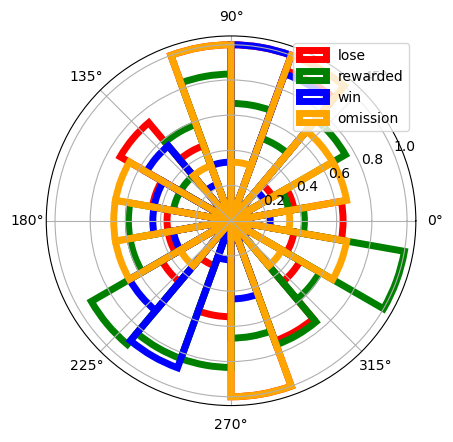

[ 0.  9.  8. 14. 10. 10. 12. 11.  6. 12. 11.  9. 12. 11. 15.  8. 14.  8.
  6.]
[ 0. 12. 15. 10.  9. 11. 14. 14.  7.  9.  8.  5. 17.  6. 20. 13. 14.  5.
  6.]
[0. 6. 7. 9. 8. 7. 2. 5. 3. 2. 7. 6. 2. 4. 3. 5. 9. 5. 5.]
[0. 3. 1. 4. 2. 1. 3. 1. 2. 3. 5. 6. 3. 5. 7. 2. 6. 1. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


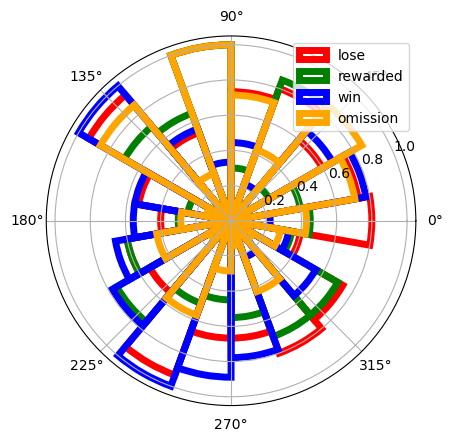

[ 0.  9.  8.  4. 11.  7.  4.  7.  7.  3.  5.  7. 14. 11. 13.  4.  3.  4.
  8.]
[ 0. 38. 36. 27. 17. 20. 28. 24. 28. 19. 21. 31. 31. 25. 24. 29. 35. 26.
 32.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 5. 5. 5. 5. 2. 5. 4. 1. 4. 2. 3. 3. 4. 3. 6. 5. 7. 4.]
[0. 3. 1. 0. 1. 4. 4. 3. 3. 2. 3. 2. 3. 0. 3. 1. 2. 1. 0.]


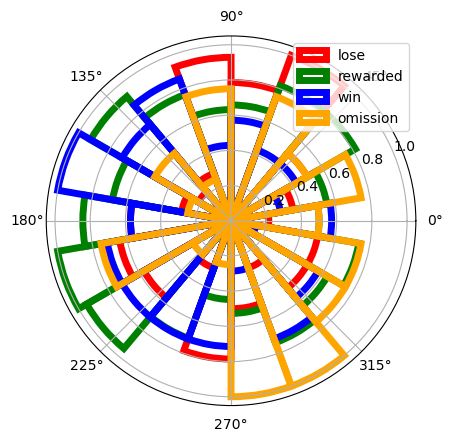

[ 0.  7. 10.  9.  5.  6.  8. 10.  9.  7.  2.  5.  8.  8.  6.  9.  5. 11.
  6.]
[ 0. 17. 14. 22. 18. 14. 17. 11. 16. 15.  7. 22. 11. 20. 22. 12. 10. 16.
  9.]
[0. 0. 2. 3. 2. 2. 1. 2. 1. 2. 1. 0. 1. 3. 3. 1. 1. 0. 1.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


[0. 3. 1. 2. 4. 4. 5. 3. 6. 6. 1. 5. 1. 6. 0. 2. 4. 1. 6.]


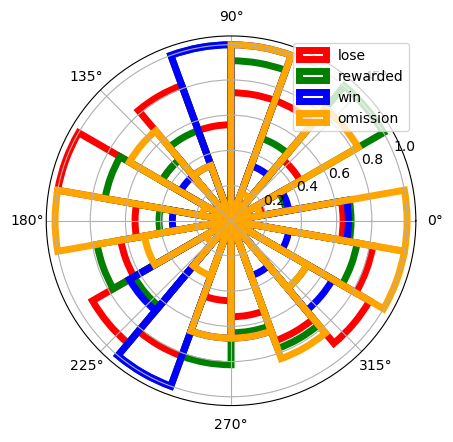

[ 0. 10. 12. 17. 15. 16. 13. 14.  9.  7. 12. 11. 15. 10. 10.  9.  7.  8.
 10.]
[ 0.  8.  5. 13.  4.  9.  6.  6.  4.  7.  5.  6. 10.  9. 10. 12.  4.  7.
  4.]
[ 0. 12. 11.  7. 12. 12.  5.  4.  3.  7. 10. 10.  7.  6.  8.  7. 11.  6.
 13.]
[0. 5. 6. 2. 4. 6. 2. 5. 0. 2. 3. 4. 2. 1. 3. 2. 1. 4. 2.]


/tmp/ipykernel_306692/3678081341.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


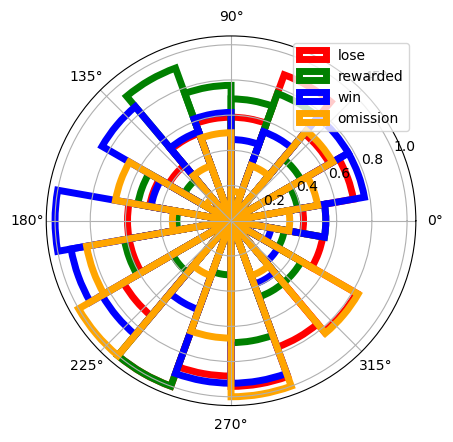

In [296]:
id_and_outcome_to_ppc = []
for id in range(len(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique())):
    fig, ax = plt.subplots()
    
    for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
    
        outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()[id])]
        
        spike_phases = outcome_df["mPFC_trial_spike_phase"]
    
        n_bins = 18
        phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
        binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
        spike_phase_hist = np.zeros(n_bins+1)
        for bin in range(0, n_bins + 1):
            spike_phase_hist[bin] = np.sum(binned_phases == bin)
        print(spike_phase_hist)
        
        #Plot
        ax = plt.subplot(1,1,1, polar=True)
        # plt.bar(phase_bins, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=phase_bins[1] - phase_bins[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
        plt.bar(phase_bins, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=phase_bins[1] - phase_bins[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
        ppc_val = PPC(spike_phases)
        id_and_outcome_to_ppc.append({"cluster_id_with_file_name": TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()[id], "outcome": outcome, "ppc": ppc_val})

    plt.legend()
    plt.show()

In [300]:
ppc_df = pd.DataFrame(id_and_outcome_to_ppc).dropna()

In [301]:
ppc_df

id   outcome       ppc
0     0      lose -0.000434
1     0  rewarded -0.000288
4     1      lose -0.000198
5     1  rewarded  0.001819
8     2      lose  0.001446
..   ..       ...       ...
219  54  omission  0.003806
220  55      lose  0.004576
221  55  rewarded -0.003852
222  55       win  0.008074
223  55  omission  0.015479

[196 rows x 3 columns]

/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='outcome', ylabel='ppc'>

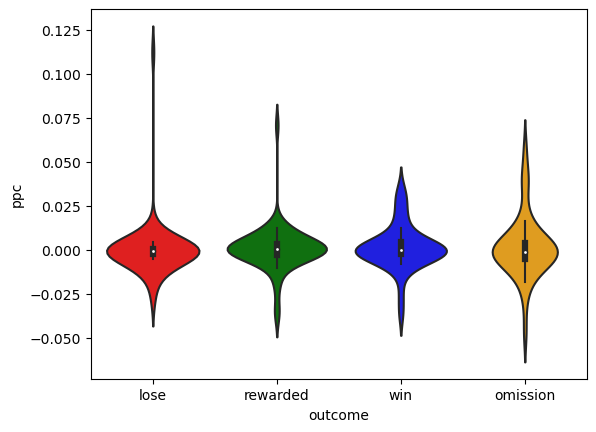

In [313]:
    sns.violinplot(x=ppc_df['outcome'], y=ppc_df['ppc'], palette=BASELINE_OUTCOME_TO_COLOR)

/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

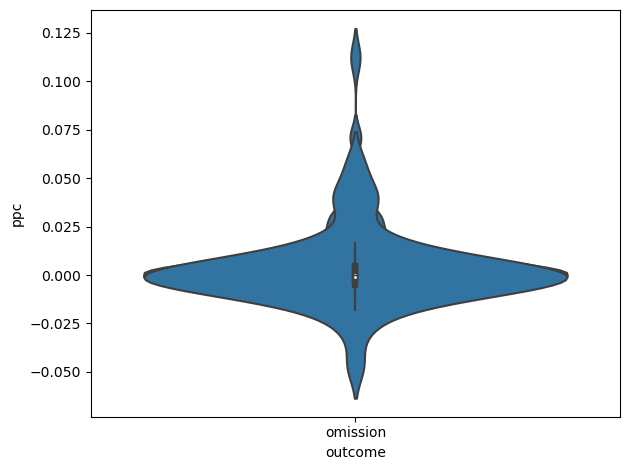

In [311]:
fig, ax = plt.subplots()

# Create a separate violin plot for each group
for i, group in enumerate(ppc_df["outcome"].unique()):
    group_data = ppc_df[ppc_df['outcome'] == group]  # filter the data for this group
    sns.violinplot(x=group_data['outcome'], y=group_data['ppc'])
    # axs[i].set_title(f'Violin plot for {group}')

plt.tight_layout()
plt.show()

/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

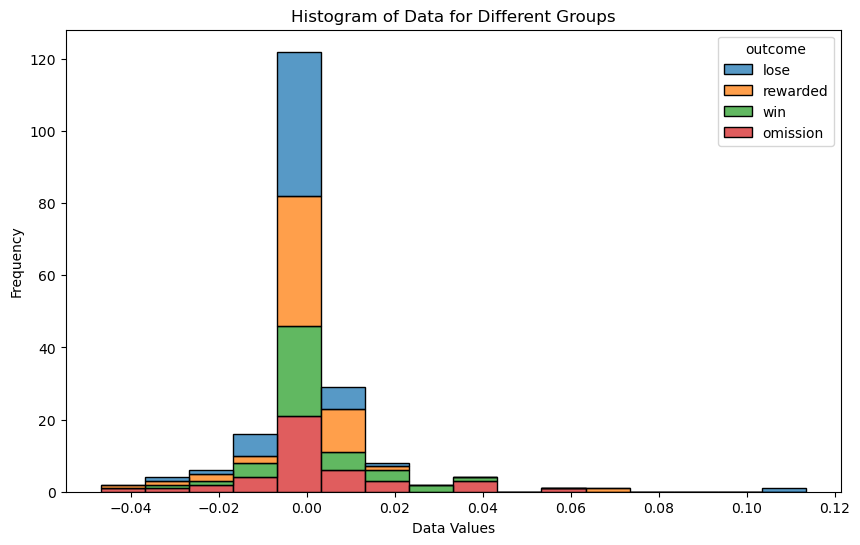

In [308]:
# Create a histogram with Seaborn's 'histplot'
plt.figure(figsize=(10, 6))
sns.histplot(data=ppc_df, x='ppc', hue='outcome', multiple="stack", binwidth=0.01)

# Set labels and title
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Different Groups')

# Show plot
plt.show()

In [214]:
spike_phases = TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

[   0. 5893. 6019. 6150. 5904. 5991. 5587. 5539. 5423. 5557. 5591. 5615.
 5608. 5765. 5907. 5699. 6003. 5827. 5921.]


<BarContainer object of 19 artists>

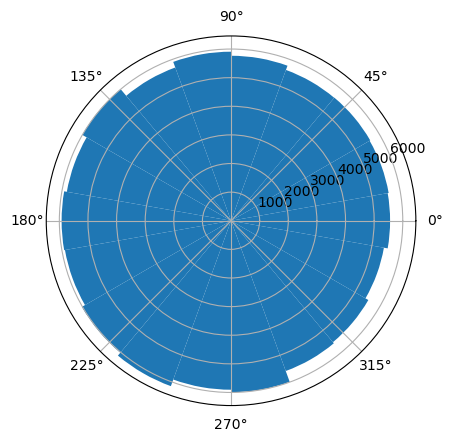

In [215]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)

# OLD MERGING CODE

In [195]:
raise ValueError()

ValueError: 

In [149]:
BASIC_LFP_TRACES_DF["spike_df"] = BASIC_LFP_TRACES_DF.apply(lambda x: MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_name"] == x["recording_file"]) & (MERGED_SPIKE_TRIAL_DF["closest_trial"] == x["time_stamp_index"])], axis=1)

In [155]:
BASIC_LFP_TRACES_DF["has_spike_df"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: not x.empty)

In [156]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["has_spike_df"]].reset_index(drop=True)

In [179]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  \
81846      509822             204      5177832         204           1   
81847      509823             134      5178486         134           5   
81848      509824              44      5178701          44           3   
81849      509825             134      5178825         134           5   
81850      509826              44      5178986          44           3   
...           ...             ...          ...         ...         ...   
83174      511150             137      5576344         137           0   
83175      511151             146      5576464         146           0   
83176      511152             187      5576807         187           0   
83177      511153              28      5576824          28           0   
83178      511154             137      5577341         137           0   

       1ms_isi  2ms_isi        amp  ch  channel_group  ...  group  n_spikes  \
81846        0        1  11.366614   6            0.0  ...   good     16516   
81847        4       17   8.562255   2            0.0  ...   good     29937   
81848        1       29   9.739503  17            0.0  ...   good     28280   
81849        4       17   8.562255   2            0.0  ...   good     29937   
81850        1       29   9.739503  17            0.0  ...   good     28280   
...        ...      ...        ...  ..            ...  ...    ...       ...   
83174        0        1  14.356270   6            0.0  ...   good     12504   
83175        0        0  14.943707   6            0.0  ...   good      1433   
83176        0        1   8.631100  14            0.0  ...   good      3354   
83177        0        0  11.487349  12            0.0  ...   good      1772   
83178        0        1  14.356270   6            0.0  ...   good     12504   

      sh  si_unit_id                                     recording_name  \
81846  0        17.0  20230619_115321_standard_comp_to_omission_D3_s...   
81847  0        11.0  20230619_115321_standard_comp_to_omission_D3_s...   
81848  0        46.0  20230619_115321_standard_comp_to_omission_D3_s...   
81849  0        11.0  20230619_115321_standard_comp_to_omission_D3_s...   
81850  0        46.0  20230619_115321_standard_comp_to_omission_D3_s...   
...   ..         ...                                                ...   
83174  0        17.0  20230619_115321_standard_comp_to_omission_D3_s...   
83175  0        18.0  20230619_115321_standard_comp_to_omission_D3_s...   
83176  0        36.0  20230619_115321_standard_comp_to_omission_D3_s...   
83177  0        30.0  20230619_115321_standard_comp_to_omission_D3_s...   
83178  0        17.0  20230619_115321_standard_comp_to_omission_D3_s...   

       timestamp_isi current_isi  closest_trial  \
81846         1726.0     0.08630        5377470   
81847         2622.0     0.13110        5377470   
81848         3215.0     0.16075        5377470   
81849          339.0     0.01695        5377470   
81850          285.0     0.01425        5377470   
...              ...         ...            ...   
83174          351.0     0.01755        5377470   
83175         1031.0     0.05155        5377470   
83176         3089.0     0.15445        5377470   
83177         1853.0     0.09265        5377470   
83178          997.0     0.04985        5377470   

       ephys_sample_from_trial_onset  lfp_sample_from_trial_onset  
81846                        -199638                        -9982  
81847                        -198984                        -9950  
81848                        -198769                        -9939  
81849                        -198645                        -9933  
81850                        -198484                        -9925  
...                              ...                          ...  
83174                         198874                         9943  
83175                         198994                         9949  
83176                         199337       

In [180]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: {k: sorted(list(v)) for k, v in x.groupby("cluster_id")["lfp_sample_from_trial_onset"]})

In [187]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: x.groupby("cluster_id")["lfp_sample_from_trial_onset"].apply(list).reset_index(name='lfp_sample_from_trial_onset'))

In [189]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

cluster_id                        lfp_sample_from_trial_onset
0           11  [-9733, -9321, -8157, -7715, -7393, -6829, -67...
1           28                    [-8128, 9545, 9834, 9875, 9967]
2           44  [-9939, -9925, -9806, -9503, -9290, -9270, -90...
3           75  [-8647, -7910, -6868, -6676, -6619, -6408, -55...
4          132  [-9354, -9294, -9236, -9082, -9015, -8959, -89...
5          134  [-9950, -9933, -9878, -9813, -9789, -9749, -95...
6          137  [-9894, -9807, -9783, -9730, -9672, -9599, -93...
7          146  [-408, 367, 462, 4348, 5600, 5612, 5648, 5684,...
8          186  [-9247, -7419, -1149, -966, 254, 1619, 2642, 3...
9          187  [-9826, -9585, -9466, -9376, -8215, -6295, -60...
10         204  [-9982, -9884, -9788, -9608, -9510, -9414, -93...
11         241                           [-4917, 110, 2533, 5992]
12         242  [-9760, -9637, -9477, -9372, -8836, -8362, -78...
13         245  [-8694, -8379, -8112, -7876, -7612, -7498, -73...

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [158]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   7019726  20230619_115321_standard_comp_to_omission_D3_s...   
1   9119725  20230619_115321_standard_comp_to_omission_D3_s...   
2  14619719  20230619_115321_standard_comp_to_omission_D3_s...   
3  15619721  20230619_115321_standard_comp_to_omission_D3_s...   
4  17219723  20230619_115321_standard_comp_to_omission_D3_s...   

                                      recording_file  time_stamp_index  \
0  20230619_115321_standard_comp_to_omission_D3_s...           5377470   
1  20230619_115321_standard_comp_to_omission_D3_s...           7477469   
2  20230619_115321_standard_comp_to_omission_D3_s...          12977463   
3  20230619_115321_standard_comp_to_omission_D3_s...          13977465   
4  20230619_115321_standard_comp_to_omission_D3_s...          15577467   

                                          video_file  video_frame  \
0  20230619_115321_standard_comp_to_omission_D3_s...         5367   
1  20230619_115321_standard_comp_to_omission_D3_s...         7464   
2  20230619_115321_standard_comp_to_omission_D3_s...        12953   
3  20230619_115321_standard_comp_to_omission_D3_s...        13951   
4  20230619_115321_standard_comp_to_omission_D3_s...        15548   

   video_number    subject_info competition_closeness  \
0           4.0  1-4_t3b3L_box2             lose_comp   
1           4.0  1-4_t3b3L_box2             lose_comp   
2           4.0  1-4_t3b3L_box2             lose_comp   
3           4.0  1-4_t3b3L_box2             lose_comp   
4           4.0  1-4_t3b3L_box2             lose_comp   

                                          video_name  ...  \
0  20230619_115321_standard_comp_to_omission_D3_s...  ...   
1  20230619_115321_standard_comp_to_omission_D3_s...  ...   
2  20230619_115321_standard_comp_to_omission_D3_s...  ...   
3  20230619_115321_standard_comp_to_omission_D3_s...  ...   
4  20230619_115321_standard_comp_to_omission_D3_s...  ...   

                               LH_baseline_lfp_trace  \
0  [0.9004575, 0.4485425, 0.2596825, 1.11967, 1.9...   
1  [0.7992825, 0.84987, 0.7790475, 0.7250875, 0.8...   
2  [-0.047215, 0.613795, 1.1162975, 1.53786, 1.65...   
3  [-1.6424075, -1.746955, -1.67276, -1.3119025, ...   
4  [0.7992825, 0.9443, 0.93081, 0.97128, 1.072455...   

                                  LH_trial_lfp_trace  \
0  [-0.33725, -0.4552875, -0.6036775, -0.964535, ...   
1  [-0.8734775, -0.924065, -0.6745, -0.49913, -0....   
2  [-0.6306575, -0.5766975, -0.8330075, -1.10618,...   
3  [0.1787425, 0.1787425, 0.0775675, -0.18886, -0...   
4  [0.4687775, 1.328765, 1.0690825, -0.2124675, -...   

                               MD_baseline_lfp_trace  \
0  [0.35191303, -0.058652174, -0.029326087, 0.876...   
1  [0.6745, 0.7168599, 0.57348794, 0.49854347, 0....   
2  [-0.22157487, 0.3747222, 0.8276473, 1.1241666,...   
3  [-1.5249565, -1.5542827, -1.4272029, -1.075289...   
4  [0.39427295, 0.44314975, 0.49202657, 0.6712415...   

                                  MD_trial_lfp_trace  \
0  [-0.84068114, -1.0818068, -1.349, -1.6129348, ...   
1  [-1.0101207, -1.1078744, -0.98405313, -0.76247...   
2  [-0.59955555, -0.62236476, -0.7950628, -0.9775...   
3  [0.42359903, 0.5180942, 0.33887923, -0.1433719...   
4  [0.4627005, 1.2154034, 0.8048382, -0.45944202,...   

                             lfp_trial_all_lfp_index  \
0  [268873, 268874, 268875, 268876, 268877, 26887...   
1  [373873, 373874, 373875, 373876, 373877, 37387...   
2  [648873, 648874, 648875, 648876, 648877, 64887...   
3  [698873, 698874, 698875, 698876, 698877, 69887...   
4  [778873, 778874, 778875, 778876, 778877, 77887...   

                          lfp_baseline_all_lfp_index  \
0  [258873, 258874, 258875, 258876, 258877, 25887...   
1  [363873, 363874, 363875, 363876, 363877, 36387...   
2  [638873, 638874, 638875, 638876, 638877, 63887...   
3  [688873, 688874, 688875, 688876, 688877, 68887...   
4  [768873, 768874, 768875, 768876, 768877, 76887...   

                  

In [159]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [160]:
FREQ_BAND = [4, 12]


In [161]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [165]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0       12653              64      5557899          64           4        1   
1       12654              89      5557965          89          11       11   
2       12655              60      5558325          60           0        0   
3       12656              64      5559142          64           4        1   
4       12657              89      5559232          89          11       11   

   2ms_isi        amp  ch  channel_group  ...  group  n_spikes sh  si_unit_id  \
0       12  10.794415  14            0.0  ...   good     26442  0         9.0   
1       13  17.238409  26            0.0  ...   good     53080  0        21.0   
2        0  26.088383   5            0.0  ...   good     11163  0         6.0   
3       12  10.794415  14            0.0  ...   good     26442  0         9.0   
4       13  17.238409  26            0.0  ...   good     53080  0        21.0   

                                      recording_name  timestamp_isi  \
0  20230620_114347_standard_comp_to_omission_D4_s...         5967.0   
1  20230620_114347_standard_comp_to_omission_D4_s...         1820.0   
2  20230620_114347_standard_comp_to_omission_D4_s...         5792.0   
3  20230620_114347_standard_comp_to_omission_D4_s...         1243.0   
4  20230620_114347_standard_comp_to_omission_D4_s...         1267.0   

  current_isi  closest_trial  ephys_sample_from_trial_onset  \
0     0.29835        5757314                        -199415   
1     0.09100        5757314                        -199349   
2     0.28960        5757314                        -198989   
3     0.06215        5757314                        -198172   
4     0.06335        5757314                        -198082   

   lfp_sample_from_trial_onset  
0                        -9971  
1                        -9968  
2                        -9950  
3                        -9909  
4                        -9905  

[5 rows x 22 columns]

(0.0, 10000.0)

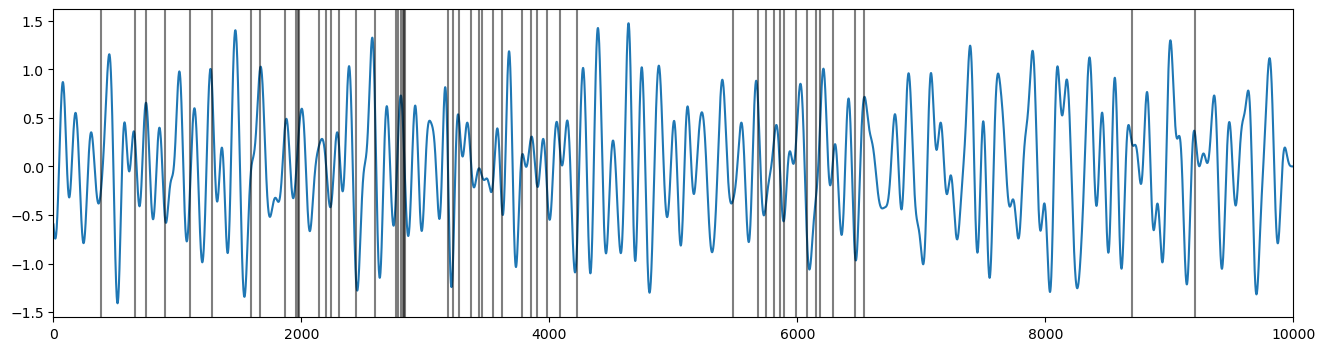

In [178]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

current_spike_df = BASIC_LFP_TRACES_DF["spike_df"].iloc[0]
current_unit_spikes = current_spike_df[current_spike_df["cluster_id"] == current_spike_df["cluster_id"].unique()[0]]["lfp_sample_from_trial_onset"].values

for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

(0.0, 10000.0)

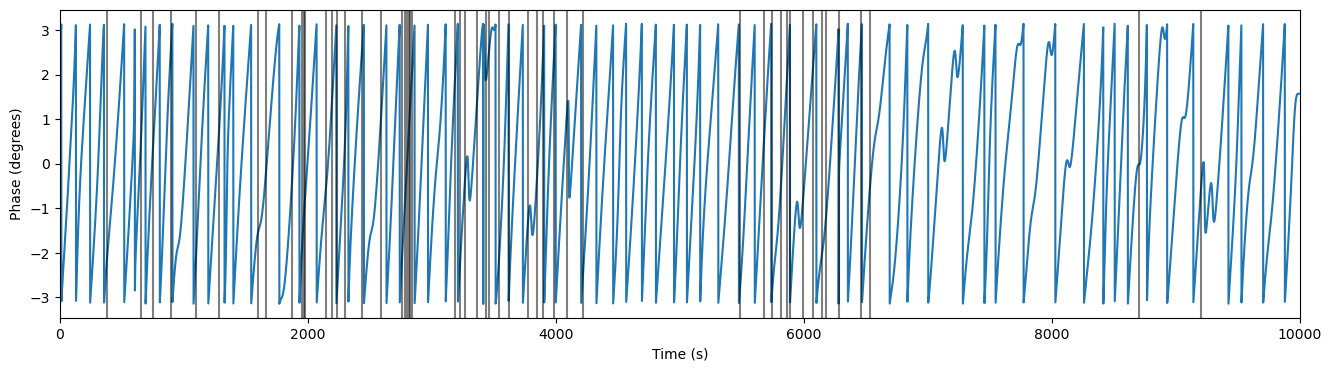

In [172]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)
for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [39]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                                  BLA_trial_filtered  \
0  [-0.1270232139593776, -0.13550809575176323, -0...   
1  [0.06167014683416184, 0.04540589200067514, 0.0...   
2  [0.09910481914715255, 0.10104307136384137, 0.1...   
3  [0.8079986776507001, 0.802581616330127, 0.7956...   
4  [-0.254415931077215, -0.2409205597620281, -0.2...   

                                     BLA_trial_phase  \
0  [2.0921499379288093, 2.318664933741562, 2.3488...   
1  [1.1931051596958737, 1.364677985966047, 1.4456...   
2  [-0.927968248659119, -0.5873130086540211, -0.5...   
3  [-0.7483757898044902, -0.25297448987131416, -0...   
4  [2.582987879734853, -3.0482235776078555, -2.99...   

                                LH_baseline_filtered  \
0  [0.056868270266307065, 0.04576024370573059, 0....   
1  [-0.6310182399173343, -0.6028305711469237, -0....   
2  [0.1465498150487816, 0.15518114144873194, 0.16...   
3  [-0.12212974143207109, -0.0897303594412939, -0...   
4  [-0.057397393662318, -0.04698434364269451, -0....   

                                   LH_baseline_phase  \
0  [-0.8294859902205611, -0.29035528041932773, -0...   
1  [2.70317941107642, -2.8854240753310387, -2.816...   
2  [-1.214160090156733, -1.1087585375109443, -1.0...   
3  [-2.0406652731308466, -1.8131783573628426, -1....   
4  [-2.8402555412201433, -2.1980502765251595, -2....   

                                   LH_trial_filtered  \
0  [0.1633071968546726, 0.16612519566931022, 0.16...   
1  [0.08406742217288202, 0.054967079728184, 0.025...   
2  [0.1440232256165005, 0.17112191208887603, 0.19...   
3  [0.881736402579422, 0.8389485366589725, 0.7945...   
4  [0.07969558521319708, 0.09709934263189805, 0.1...   

                                      LH_trial_phase  \
0  [-0.8714076735108721, -0.5086576686505543, -0....   
1  [1.2979990285889775, 1.4315598190373768, 1.508...   
2  [-1.2734754133841686, -1.1716494030565592, -1....   
3  [-0.4412991310421433, 0.2551244873375817, 0.32...   
4  [-1.3590004890828478, -1.292010156609553, -1.2...   

      

In [193]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

cluster_id                        lfp_sample_from_trial_onset
0           11  [-9733, -9321, -8157, -7715, -7393, -6829, -67...
1           28                    [-8128, 9545, 9834, 9875, 9967]
2           44  [-9939, -9925, -9806, -9503, -9290, -9270, -90...
3           75  [-8647, -7910, -6868, -6676, -6619, -6408, -55...
4          132  [-9354, -9294, -9236, -9082, -9015, -8959, -89...
5          134  [-9950, -9933, -9878, -9813, -9789, -9749, -95...
6          137  [-9894, -9807, -9783, -9730, -9672, -9599, -93...
7          146  [-408, 367, 462, 4348, 5600, 5612, 5648, 5684,...
8          186  [-9247, -7419, -1149, -966, 254, 1619, 2642, 3...
9          187  [-9826, -9585, -9466, -9376, -8215, -6295, -60...
10         204  [-9982, -9884, -9788, -9608, -9510, -9414, -93...
11         241                           [-4917, 110, 2533, 5992]
12         242  [-9760, -9637, -9477, -9372, -8836, -8362, -78...
13         245  [-8694, -8379, -8112, -7876, -7612, -7498, -73...

In [ ]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

# Plotting phase and LFP

In [119]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  \
81846      509822             204      5177832         204           1   
81847      509823             134      5178486         134           5   
81848      509824              44      5178701          44           3   
81849      509825             134      5178825         134           5   
81850      509826              44      5178986          44           3   
...           ...             ...          ...         ...         ...   
83174      511150             137      5576344         137           0   
83175      511151             146      5576464         146           0   
83176      511152             187      5576807         187           0   
83177      511153              28      5576824          28           0   
83178      511154             137      5577341         137           0   

       1ms_isi  2ms_isi        amp  ch  channel_group  ...  n_spikes  sh  \
81846        0        1  11.366614   6            0.0  ...     16516   0   
81847        4       17   8.562255   2            0.0  ...     29937   0   
81848        1       29   9.739503  17            0.0  ...     28280   0   
81849        4       17   8.562255   2            0.0  ...     29937   0   
81850        1       29   9.739503  17            0.0  ...     28280   0   
...        ...      ...        ...  ..            ...  ...       ...  ..   
83174        0        1  14.356270   6            0.0  ...     12504   0   
83175        0        0  14.943707   6            0.0  ...      1433   0   
83176        0        1   8.631100  14            0.0  ...      3354   0   
83177        0        0  11.487349  12            0.0  ...      1772   0   
83178        0        1  14.356270   6            0.0  ...     12504   0   

      si_unit_id                                     recording_name  \
81846       17.0  20230619_115321_standard_comp_to_omission_D3_s...   
81847       11.0  20230619_115321_standard_comp_to_omission_D3_s...   
81848       46.0  20230619_115321_standard_comp_to_omission_D3_s...   
81849       11.0  20230619_115321_standard_comp_to_omission_D3_s...   
81850       46.0  20230619_115321_standard_comp_to_omission_D3_s...   
...          ...                                                ...   
83174       17.0  20230619_115321_standard_comp_to_omission_D3_s...   
83175       18.0  20230619_115321_standard_comp_to_omission_D3_s...   
83176       36.0  20230619_115321_standard_comp_to_omission_D3_s...   
83177       30.0  20230619_115321_standard_comp_to_omission_D3_s...   
83178       17.0  20230619_115321_standard_comp_to_omission_D3_s...   

       timestamp_isi  current_isi closest_trial  time_from_trial_onset  \
81846         1726.0      0.08630       5377470                -199638   
81847         2622.0      0.13110       5377470                -198984   
81848         3215.0      0.16075       5377470                -198769   
81849          339.0      0.01695       5377470                -198645   
81850          285.0      0.01425       5377470                -198484   
...              ...          ...           ...                    ...   
83174          351.0      0.01755       5377470                 198874   
83175         1031.0      0.05155       5377470                 198994   
83176         3089.0      0.15445       5377470                 199337   
83177         1853.0      0.09265       5377470                 199354   
83178          997.0      0.04985       5377470                 199871   

       ephys_sample_from_trial_onset  lfp_sample_from_trial_onset  
81846                        -199638                        -9982  
81847                        -198984                        -9950  
81848                        -198769                        -9939  
81849                        -198645                        -9933  
81850                        -198484                        -9925  
...                              ...                   

In [88]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[5].columns

Index(['Unnamed: 0', 'spike_clusters', 'spike_times', 'cluster_id',
       '1_5_ms_isi', '1ms_isi', '2ms_isi', 'amp', 'ch', 'channel_group',
       'depth', 'fr', 'group', 'n_spikes', 'sh', 'si_unit_id',
       'recording_name', 'timestamp_isi', 'current_isi', 'closest_trial'],
      dtype='object')

In [87]:
BASIC_LFP_TRACES_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [45]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [46]:
example_trial = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["recording_file"] == rec_file].iloc[15]

In [47]:
example_trial.index

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [48]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [49]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [50]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [57]:
example_spike_df[["spike_clusters", "spike_times"]]

spike_clusters  spike_times
58068              64     29858392
58069              89     29858818
58070              89     29860378
58071              64     29860572
58072              89     29860625
...               ...          ...
58617              60     30056342
58618              89     30056437
58619              60     30056651
58620              89     30057493
58621              94     30057539

[554 rows x 2 columns]

In [56]:
example_spike_df

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  \
58068       58068              64     29858392          64           4   
58069       58069              89     29858818          89          11   
58070       58070              89     29860378          89          11   
58071       58071              64     29860572          64           4   
58072       58072              89     29860625          89          11   
...           ...             ...          ...         ...         ...   
58617       58617              60     30056342          60           0   
58618       58618              89     30056437          89          11   
58619       58619              60     30056651          60           0   
58620       58620              89     30057493          89          11   
58621       58621              94     30057539          94           1   

       1ms_isi  2ms_isi        amp  ch  channel_group  depth         fr group  \
58068        1       12  10.794415  14            0.0  280.0   7.735803  good   
58069       11       13  17.238409  26            0.0  520.0  15.528948  good   
58070       11       13  17.238409  26            0.0  520.0  15.528948  good   
58071        1       12  10.794415  14            0.0  280.0   7.735803  good   
58072       11       13  17.238409  26            0.0  520.0  15.528948  good   
...        ...      ...        ...  ..            ...    ...        ...   ...   
58617        0        0  26.088383   5            0.0  100.0   3.265818  good   
58618       11       13  17.238409  26            0.0  520.0  15.528948  good   
58619        0        0  26.088383   5            0.0  100.0   3.265818  good   
58620       11       13  17.238409  26            0.0  520.0  15.528948  good   
58621        0        1  22.982307  20            0.0  400.0   0.664105  good   

       n_spikes  sh  si_unit_id  \
58068     26442   0         9.0   
58069     53080   0        21.0   
58070     53080   0        21.0   
58071     26442   0         9.0   
58072     53080   0        21.0   
...         ...  ..         ...   
58617     11163   0         6.0   
58618     53080   0        21.0   
58619     11163   0         6.0   
58620     53080   0        21.0   
58621      2270   0        15.0   

                                          recording_name  timestamp_isi  \
58068  20230620_114347_standard_comp_to_omission_D4_s...         2849.0   
58069  20230620_114347_standard_comp_to_omission_D4_s...         2806.0   
58070  20230620_114347_standard_comp_to_omission_D4_s...         1560.0   
58071  20230620_114347_standard_comp_to_omission_D4_s...         2180.0   
58072  20230620_114347_standard_comp_to_omission_D4_s...          247.0   
...                                                  ...            ...   
58617  20230620_114347_standard_comp_to_omission_D4_s...         1587.0   
58618  20230620_114347_standard_comp_to_omission_D4_s...          749.0   
58619  20230620_114347_standard_comp_to_omission_D4_s...          309.0   
58620  20230620_114347_standard_comp_to_omission_D4_s...         1056.0   
58621  20230620_114347_standard_comp_to_omission_D4_s...        31620.0   

       current_isi  closest_trial  
58068      0.14245       29857611  
58069      0.14030       29857611  
58070      0.07800       29857611  
58071      0.10900       29857611  
58072      0.01235       29857611  
...            ...            ...  
58617      0.07935       29857611  
58618      0.03745       29857611  
58619      0.01545       29857611  
58620      0.05280       29857611  
58621      1.58100       29857611  

[554 rows x 20 columns]

In [61]:
merged_df = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [65]:
merged_df.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [58]:
BASIC_LFP_TRACES_DF

time                                      recording_dir  \
0     6310663  20221202_134600_omission_and_competition_subje...   
1     7910662  20221202_134600_omission_and_competition_subje...   
2     9710660  20221202_134600_omission_and_competition_subje...   
3    11310658  20221202_134600_omission_and_competition_subje...   
4    12810657  20221202_134600_omission_and_competition_subje...   
..        ...                                                ...   
538  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
539  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
540  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
541  70681909  20230621_111240_standard_comp_to_omission_D5_s...   
542  71681918  20230621_111240_standard_comp_to_omission_D5_s...   

                                        recording_file  time_stamp_index  \
0    20221202_134600_omission_and_competition_subje...           1390826   
1    20221202_134600_omission_and_competition_subje...           2990825   
2    20221202_134600_omission_and_competition_subje...           4790823   
3    20221202_134600_omission_and_competition_subje...           6390821   
4    20221202_134600_omission_and_competition_subje...           7890820   
..                                                 ...               ...   
538  20230621_111240_standard_comp_to_omission_D5_s...          62088794   
539  20230621_111240_standard_comp_to_omission_D5_s...          63588812   
540  20230621_111240_standard_comp_to_omission_D5_s...          65588836   
541  20230621_111240_standard_comp_to_omission_D5_s...          67488865   
542  20230621_111240_standard_comp_to_omission_D5_s...          68488874   

                                            video_file  video_frame  \
0    20221202_134600_omission_and_competition_subje...         1734   
1    20221202_134600_omission_and_competition_subje...         3728   
2    20221202_134600_omission_and_competition_subje...         5972   
3    20221202_134600_omission_and_competition_subje...         7966   
4    20221202_134600_omission_and_competition_subje...         9836   
..                                                 ...          ...   
538  20230621_111240_standard_comp_to_omission_D5_s...        62056   
539  20230621_111240_standard_comp_to_omission_D5_s...        63554   
540  20230621_111240_standard_comp_to_omission_D5_s...        65550   
541  20230621_111240_standard_comp_to_omission_D5_s...        67447   
542  20230621_111240_standard_comp_to_omission_D5_s...        68444   

     video_number      subject_info competition_closeness  \
0             1.0  6_1_top_2_base_3              rewarded   
1             1.0  6_1_top_2_base_3              rewarded   
2             1.0  6_1_top_2_base_3              rewarded   
3             1.0  6_1_top_2_base_3              omission   
4             1.0  6_1_top_2_base_3              rewarded   
..            ...               ...                   ...   
538           1.0    1-4_t3b3L_box1              rewarded   
539           1.0    1-4_t3b3L_box1              rewarded   
540           1.0    1-4_t3b3L_box1              rewarded   
541           1.0    1-4_t3b3L_box1              omission   
542           1.0    1-4_t3b3L_box1              rewarded   

                                            video_name  ...  \
0    20221202_134600_omission_and_competition_subje...  ...   
1    20221202_134600_omission_and_competition_subje...  ...   
2    20221202_134600_omission_and_competition_subje...  ...   
3    20221202_134600_omission_and_competition_subje...  ...   
4    20221202_134600_omission_and_competition_subje...  ...   
..                                                 ...  ...   
538  20230621_111240_standard_comp_to_omission_D5_s...  ...   
539  20230621_111240_standard_comp_to_omission_D5_s...  ...   
540  20230621_111240_standard_comp_to_omission_D5_s...  ...   
541  20230621_111240_standard_comp_to_omission_D5_s...  ...   


In [27]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


The group with the largest count is: 89


In [28]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [29]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [30]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

(29857611.0, 29877611.0)

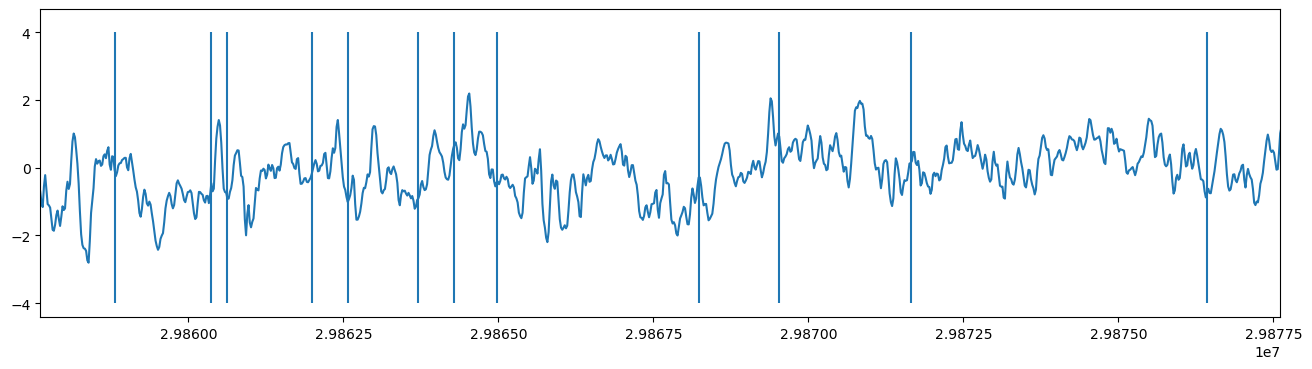

In [31]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

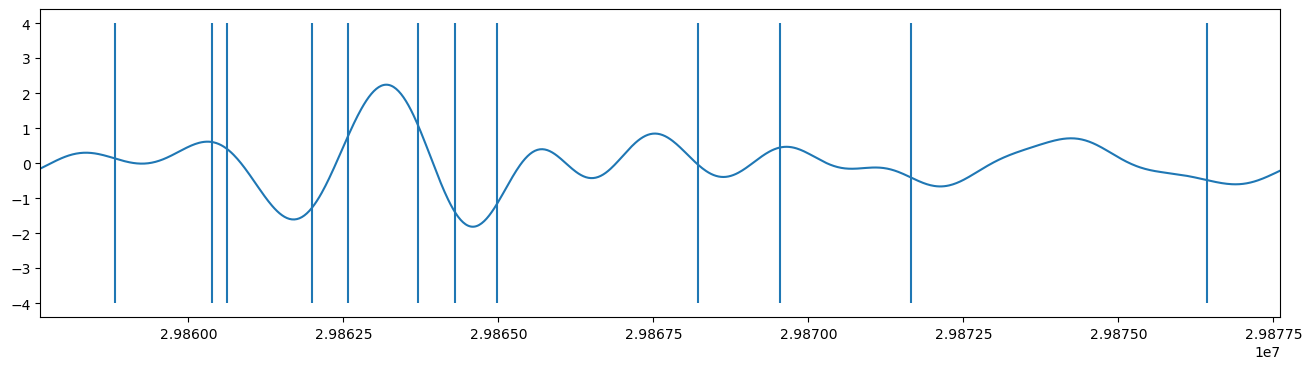

In [32]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

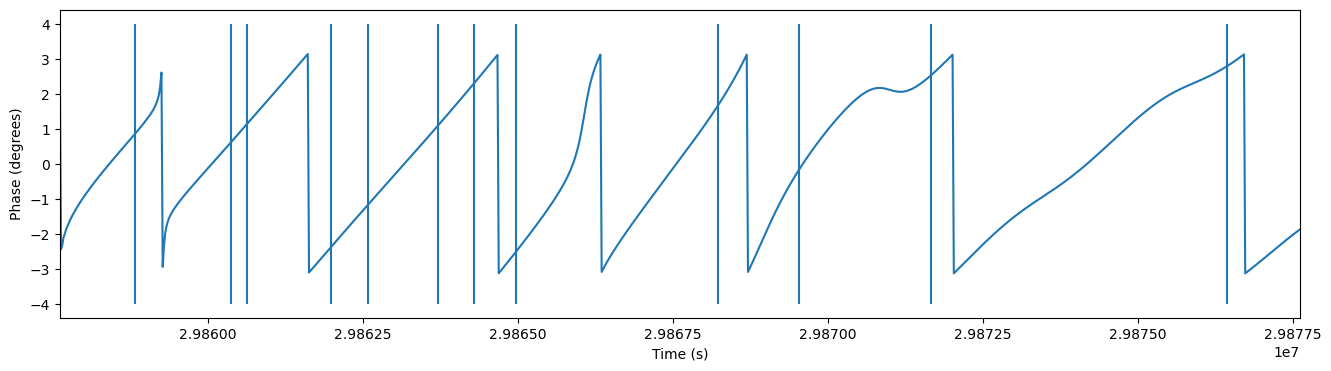

In [33]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [34]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [35]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


[ 0. 15. 12. 11. 11.  9. 13.  9.  7.  8. 12. 11. 13. 23. 14. 11. 12. 16.
  5.]


<BarContainer object of 19 artists>

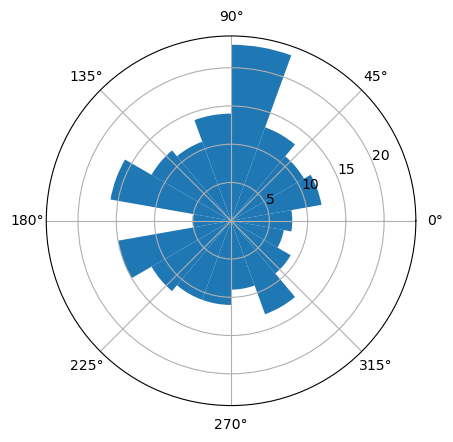

In [36]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)